In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
import retriever
from tabulate import tabulate

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
trainset_file = '../data/training/order_train_data.bin'
testset_file = '../data/training/order_test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/All/'
embed_path =  '../data/metadata/w2v.bin'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n items where each item is [bounding box vector, bounding box spaital features]. Note that different enteries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the ture bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))
print('Train set batches #:', len(trainset))
print('Train batch size:', len(trainset[0]))
print('Train set data size:', len(trainset)*len(trainset[0]))

testset = np.load(open(testset_file, 'rb'))
print('Test set batches #:', len(trainset))
print('Test Batch size:', len(trainset[0]))
print('Test set data size:', len(trainset)*len(trainset[0]))


with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Train set batches #: 297
Train batch size: 200
Train set data size: 59400
Test set batches #: 297
Test Batch size: 200
Test set data size: 59400
Number of words: 8242


In [4]:
# w2c words vectors
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)

<h3> augment_data function </h3>
<br>We try sevral regularization methods. One of the things I've tried is to add data points where for each data I pick a query from a random data point and a set of bbox from a different random point. We build the labels (bboxes) distribution by giving an equal probability to each label. <br><br>
The augment_data function does just that but the label of each added poind is writen as -1*number of bboxes. When we build the batch it self (function build_data in class Model), if we see a negative label index, we know its an added point and we know the number of bboxes so we can build the correct distribution.  

In [5]:
def augment_data(data, ratio=0.5, addNoise=False):
        '''
        The function add data points. 
        We pick a query from a random data point,
        and a set of bbox from a different random point and we join them
        to build a new data point. The label distribution of the new data point will 
        uniform, that is, all labels will have equal probability. 
        
        
        Params:
            data: a list of data entries
                                                
        Returns: a list of augmented data
            
                        
        '''
                          
        q_idx = np.random.choice(range(len(data)), int(len(data)*ratio), replace=False)
        im_idx = np.random.choice([i for i in range(len(data)) if i not in q_idx], int(len(data)*ratio))
        for i in range(len(q_idx)):
            q, im = data[q_idx[i]][0], data[im_idx[i]][1:-1]
            item = [q]
            for im_tmp in im:
                item.append(im_tmp)
            item.append(-len(im))
            data.append(item)

In [6]:
def stats(test, train, ephocs=100, title=None, params=[50, 100, 150, 200]):
    '''
    Plot metrics graphs and print some stats.
    
    Params:
        test: list. 
              Each item is a tuple, [test accuracy, test IOU, test loss]
        
        train: list. 
               Each item is a tuple, [train accuracy, train IOU, train loss, 0]
               For now we can ignore the last part in the tuple (zero)
               
        params: The hyper-parameters to iterate over, defult to number of rnn's hidden units.
    '''
    
    ephocs = range(ephocs)
    test_res = np.array(test)
    train_res = np.array(train)
    test_Glabels = ['test accuracy', 'test IOU', 'test loss']
    train_Glabels = ['train accuracy', 'train IOU', 'train loss']

    for j, param in enumerate(params):
        for i in range(len(train_Glabels)):
            plt.plot(ephocs, test_res[j][:,i])
            plt.plot(ephocs, train_res[j][:,i])
            plt.legend([test_Glabels[i], train_Glabels[i]], loc='upper left')
            if title is not None:
                plt.title('%s: %0.3f'%(title, param))
            plt.show()

            metric = ''.join(train_Glabels[i][len('train')+1:])
            if metric=='loss':
                print('Train min %s:%.3f'%(metric, min(train_res[j][:,i])))
                print('Test min %s:%.3f'%(metric, min(test_res[j][:,i])))
            else:
                print('Train max %s:%.3f'%(metric, max(train_res[j][:,i])))
                print('Test max %s:%.3f'%(metric, max(test_res[j][:,i])))
        print('-'*100,'\n')

# ALSTM

After running B with no edited words we use this RNN cell which has two LSTM cells, Bcell (for player B) and Acell (for Player A). If is Edit is False, we just run B's cell else it works as follow:
<ol> 
<li>We run B's cells with the true query input word, getting the un-edited state. If use_worsAttn=True we add attention on the images vectors for each word.</li>
<li>We run B's cells with the edited input word - 'unk', getting the edited state. If use_worsAttn=True we add attention on the images vectors for each word.</li>
<li>A uses attention mechanism over all B's outputs on the unedited words (which we got before using this cell).</li>
<li>A's input are:
<ul><li>B's unedited state</li><li>The reward for editing a word</li><li>B's loss having no edited words.</li></ul></li>
<br><li>A's output is then goes throw a transformation which yields two values, one for editing a word and another for not:
<ul>
    <li>With probability of editRandomlyProb we ignore A and decide whether to edit or not with probability of rnn_editProb</li>
    <li>With probability of 1-editRandomlyProb A chooses an action: edit only if the value for edit the word is higher (i.e. we pass B's edited state to the next time step), else we pass B's unedited state.</li></ul>.</li>
</ol>

In [7]:
class ALSTM(tf.nn.rnn_cell.LSTMCell):
    def __init__(self, 
                 batch_size, 
                 num_units, 
                 
                 # Size of A's attention vector.
                 words_attn_dim, 
                 # B's outputs (for each time step).
                 words_attn_states, 
                 # Inicates whether attentionvec is a padding (0) or not (1).
                 words_attn_idx, 
                 
                 # Size of B's attention vector ([image vector, spital features] size) .
                 img_attn_dim, 
                 # B's outputs (for each time step).
                 img_attn_states, 
                 
                 
                 # Inicates whether attentionvec is a padding (0) or not (1).
                 img_attn_idx, 
                 
                 unk, #'unk' word vector
                 
                 # Probabilty for choosing an action (edit or not) randomly, 
                 editRandomlyProb, 
                 # Probabilty for edit a word in rnn, when decision are taken randomly.
                 rnn_editProb, 
                 
                 
                 # Whehter to edit the query or not.
                 isEdit, 
                 
                 # Whether B uses words levlel attention or not.
                 use_wordAttn,
                 
                 # If isIDX is True then use the decisions in set_actions.
                 isIDX,
                 set_actions=None,
                 
                 
                 # Word vector size 
                 word_size=100,
                 
                 # If True add noise instead of using 'unk'
                 useNoise=False,
                 
                 # If useNoise is true word vec = alpha*word_vector+(1-alpha)*noise
                 alpha=.3,
                 
                 # Dropout ratio for rnn's inputs and outpouts
                 dropout_in=1.,
                 dropout_out=1.,
                 
                 #this holds A's rewards and B's losses to
                 # be add to A's feature vectors.
                 reward_loss=None,
                 state_is_tuple=True,):
        
        
        # When useing A, the cell state will contain the concatenation 
        # of both B and A states. Therefore we set the unit number to be
        # 2*(A and B unit size).
        super().__init__(2*num_units+1, state_is_tuple=state_is_tuple)
    
        self.words_attn_states = words_attn_states
        self.words_attn_idx = words_attn_idx
        self.words_attn_dim = words_attn_dim
        
        self.img_attn_states = img_attn_states
        self.img_attn_idx = img_attn_idx
        self.img_attn_dim = img_attn_dim
        
        self.num_units = num_units
        self.batch_size = batch_size
        self.unk = unk 
        self.isEdit = isEdit
        self.use_wordAttn=use_wordAttn
        
        # To avoide using dropout twice on the same input, if isEdit is true
        # Bcell will only use dropout for its inputs. We'll add dropout to B's outputs
        # only after A's action was taken.
        self.Acell = tf.contrib.rnn.DropoutWrapper(
            tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True), 
            input_keep_prob=dropout_in, 
            output_keep_prob=dropout_out
        )
      
        self.Bcell_tmp = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)
            
        
        self.rnn_editProb = rnn_editProb
        self.reward_loss = reward_loss
        self.useNoise=useNoise
        self.alpha=alpha
        
        self.isIDX=isIDX
        self.set_actions=set_actions
        self.editRandomlyProb = editRandomlyProb
        self.dropout_in = dropout_in
        self.dropout_out = dropout_out
        self.word_size=word_size
        

    def call(self, inputs, state):
        '''
        Params:
            inputs: word embadding.
            state:  [B's state form privious state, A's state form privious state]
        '''
        # takse B's state from state[:self.num_units]
        Bstate_c = tf.slice(state[0], [0, 0], [-1, self.num_units])
        Bstate_h = tf.slice(state[1], [0, 0], [-1, self.num_units])
        self.Bstate =  tf.nn.rnn_cell.LSTMStateTuple(c=Bstate_c, h=Bstate_h)
        
        if self.use_wordAttn:
            words_attn = self.attention(Bstate_h, self.img_attn_states, self.img_attn_dim, self.img_attn_idx)

        
        # If isEdit==True 
        def f1(): 
            # If B's cell uses attention
            self.Bcell = tf.contrib.rnn.DropoutWrapper(
                    self.Bcell_tmp, input_keep_prob=self.dropout_in)
            
            # If B uses words level attention over BBOXes.
            if self.use_wordAttn:
                new_input = tf.concat([inputs, words_attn], -1)
                Boutputs, Bnew_state =  self.Bcell(new_input, self.Bstate, 'Bcell')
            else:
                Boutputs, Bnew_state =  self.Bcell(inputs, self.Bstate, 'Bcell')
            
            # takse A's state from state[self.num_units: 2*self.num_units]
            Astate_c = tf.slice(state[0], [0, self.num_units], [-1, self.num_units])
            Astate_h = tf.slice(state[1], [0, self.num_units], [-1, self.num_units])
            self.Astate =  tf.nn.rnn_cell.LSTMStateTuple(c=Astate_c, h=Astate_h)
            
            #Current time step is in the state[-1]
            self.timesteps = tf.slice(state[1], [0, 2*self.num_units], [-1, 1])
            self.timestep = tf.cast(self.timesteps[0][0], tf.int32)
            
            if self.useNoise: # just add noise to the edited words
                new_unk_vecs = self.alpha*inputs + (1-alpha)*tf.random_normal(shape=inputs.get_shape(), stddev=0.1)
            else: # change the edited words by 'unk'
                '''
                We build Wnoise so that when A decides to edit, the edited word's vector
                will be Wnoise[i], which is sampled from normal distribution, N(Qmean[i], Qstd[i]),
                where Qmean[i] and Qstd[i] are the same as the mean and std of the i'th 
                input's word.
                '''
                Qmean = tf.reduce_mean(inputs, axis=-1, keep_dims=True) # Qmean[i] = i'th input's word mean
                Qstd = tf.contrib.keras.backend.std(inputs, axis=-1, keepdims=True) # Qstd[i]= i'th input's word std
                Wnoise = tf.random_normal(shape=[self.batch_size, self.word_size], mean=Qmean, stddev=Qstd) 
            
            # run B's cell with unk_batch
            if self.use_wordAttn:
                new_unk = tf.concat([Wnoise, words_attn], -1)
            else:
                new_unk = Wnoise
            edit_output, edit_new_state = self.Bcell(new_unk, self.Bstate, 'Bcell')  
            out1, state1 = self.runCell(Boutputs, Bnew_state, edit_new_state)
            return out1, state1
        
        def f2(): #If we don't edit
            # If B's cell uses attention
            self.Bcell = tf.contrib.rnn.DropoutWrapper(
                    self.Bcell_tmp, output_keep_prob=self.dropout_out, input_keep_prob=self.dropout_in)
            
            if self.use_wordAttn:
                new_input = tf.concat([inputs, words_attn], -1)
                Boutputs, Bnew_state =  self.Bcell(new_input, self.Bstate, 'Bcell')
            else:
                Boutputs, Bnew_state =  self.Bcell(inputs, self.Bstate, 'Bcell')
                
            outs = tf.concat([Boutputs, tf.zeros((self.batch_size, self.num_units+1))], 1)
            new_state_c = tf.concat([Bnew_state[0], tf.zeros((self.batch_size, self.num_units+1))], 1)
            new_state_h = tf.concat([Bnew_state[1], tf.zeros((self.batch_size, self.num_units+1))], 1)
            return outs, tf.nn.rnn_cell.LSTMStateTuple(c=new_state_c, h=new_state_h)
        
        new_output, new_state = tf.cond(self.isEdit, f1, f2)
        
        return new_output, new_state
    
    def runCell(self, Boutputs, Bnew_state, edit_new_state):
        '''
        Run B's cell after editing.
        
        params:
            Boutputs: output vector without editing.
            Bnew_state: state vector without editing.
            edit_new_state: state vector after editing the input word to 'unk'. 
        '''
        
        with tf.variable_scope('runcell'):
            # get action values according to B's hidden state
            Aout, Anew_state, actions_vals = self.action_vals(Boutputs) 
            
            def g1():
                '''
                If isIDX use the decisions in self.action_idx
                '''
                return tf.slice(self.set_actions, [0,self.timestep], [-1, 1])
            
            def g2():
                # A choose to edit a word if actions_vals[0]<actions_vals[1].
                # Note: if we edit the word cond=1, else cond=0.
                a1, a2 = tf.split(value=actions_vals, num_or_size_splits=2, axis=1)
                A_choice = tf.cast(tf.less(a1, a2), tf.float32)

                # If action is chosen randomly, edit word with probability self.rnn_editProb
                # Note: if we edit the word cond=1, else cond=0.
                rand = tf.multinomial(tf.log([[self.rnn_editProb, 1-self.rnn_editProb]]), self.batch_size)
                rand_choice = tf.cast(tf.less(tf.transpose(rand), 1), tf.float32) 

                # Choose whether to edit a word randomly with probability of editRandomlyProb
                editRandomly = tf.multinomial(tf.log([[self.editRandomlyProb, 1-self.editRandomlyProb]]), self.batch_size)
                editRandomly_choice = tf.cast(tf.less(tf.transpose(editRandomly), 1), tf.float32)

                # A list of decisions for each word in the batch. actions_idx[i] = 1->edit word in query i (at this time step), 0->do not edit.
                return editRandomly_choice*rand_choice + (1-editRandomly_choice)*A_choice

            
            # a list of A's decisions for each batch.  1->edit, 0-> do not edit.
            cond = tf.cast(tf.cond(self.isIDX, g1, g2), tf.float32)

            # We'd like to know the action values and decision for each word,
            # therefore theses info are placed on the first 3 dimensions of the 
            # output vector. Note that this vector is not passed to the 
            # next tiee step so it won't affect the model. 
            outs = tf.concat([actions_vals, cond], 1)

            # B's i state is replaced by the edited state if cond[i]=1 (i =1, 2, ..., batch_size)
            new_edit_state_c = (1-cond)*Bnew_state[0] + cond*edit_new_state[0]
            new_edit_state_h = (1-cond)*Bnew_state[1] + cond*edit_new_state[1]


            new_outs = tf.concat([outs, tf.zeros((self.batch_size, 2*self.num_units-3)), self.timesteps+1], 1)
            new_state_c = tf.concat([new_edit_state_c, Anew_state[0], self.timesteps+1], 1)
            new_state_h = tf.concat([new_edit_state_h, Anew_state[1], self.timesteps+1], 1)
            return new_outs, tf.nn.rnn_cell.LSTMStateTuple(c=new_state_c, h=new_state_h)
    
    
    def action_vals(self, Boutputs):
        '''
        Get values for editing/not editing the input word.
        
        Params:
            Boutputs: output vector without editing.
            
        Returns vals where:
            Aout: A's cell output
            Anew_state: A's cell state
            vals: Tensor where vals[0] is the value for not editing the word 
                    and vals[1] is the value for editing the word.
        '''
        
        with tf.variable_scope('action_vals') as scope:
            Aattn = self.attention(self.Astate[1], self.words_attn_states, self.words_attn_dim, self.words_attn_idx)
            
            # A's input: [input, B's output, attntion state, reward, B's loss with no edits]
            Anew_inputs = tf.concat([Boutputs, Aattn, self.reward_loss], 1)
            
            Aout, Anew_state = self.Acell(Anew_inputs, self.Astate, 'Acell')
            vals = tf.nn.relu(self.linear(Aout, 2))

            # Save the variables that only A uses. 
            # These variables will be trained separately from B's model.
            self.Avars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
            
            return Aout, Anew_state, vals
            
        
    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):
        with tf.variable_scope(scope, reuse=False):
            W = tf.get_variable('W', initializer=tf.random_uniform_initializer(maxval=1., minval=-1.),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b

        return tf.matmul(inputs, W)
    
    
    def attention(self, state, attn_states, attn_dim, attn_idx, relu=False):
        '''
        Attention mechanism (see https://arxiv.org/pdf/1409.0473.pdf)
        
        state: State from previous time step.
        attn_states: Attetntion states. 
                     Tensor of shape (batch_size x max([len(attention_vectors[i]) for i in range(bach_size)]) x attn_dim)
        attn_dim: Attention vector size.
        attn_idx,: Tensor used for masking of shape (batch_size x max([len(attention_vectors[i]) for i in range(bach_size)]). 
                   attn_idx[i, j]=1 if the j's attention vcctior of sample i  is not padding, else its equat to 0.
        '''
        with tf.variable_scope('attn'):
            self.attn_length = tf.shape(attn_states)[1]  

            # Computing... hidden_attn = W*v_att (use tf.nn.conv2d for efficiency)
            attn_vecs = tf.reshape(attn_states, [self.batch_size, self.attn_length, 1, attn_dim])
            W = tf.get_variable("attn_W", [1, 1, attn_dim, self.num_units])
            hidden_attn = tf.nn.conv2d(attn_vecs, W, [1, 1, 1, 1], "SAME")

            # Computing... hidden_s = U*v_state
            hidden_s = tf.reshape(
                self.linear(
                    tf.cast(state, tf.float32), output_dim=self.num_units, scope='hidden_s_linear'), [-1, 1, 1,  self.num_units], name='hidden_s')

            # Computing alpha
            v = tf.get_variable("attn_v", [self.num_units])
            if relu:
                logits = tf.reduce_sum(v * tf.nn.relu(hidden_attn + hidden_s), [2, 3])
            else:
                logits = tf.reduce_sum(v * tf.nn.tanh(hidden_attn + hidden_s), [2, 3])

            # Masked softmax
            max_logits = tf.reduce_max(logits, axis=-1)
            masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*attn_idx
            alpha = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keep_dims=True)

            a = tf.reduce_sum(tf.reshape(alpha, [-1, self.attn_length, 1, 1]) * attn_vecs, [1, 2])
            b = tf.contrib.layers.fully_connected(a, num_outputs=self.num_units)


            return b

# Training
When A joins the game, each iteration is completed via three steps:
<ul>
<li>We feed the query as it is to B and run it alone (no optimization nor training is done at this step)</li>
<li>We calculate B's loss per query and use it to calculate the reward for query i as follow: <br> <br><b>edit_reard*Bloss_i/length_of_query_i</b><br>
<li>We run A and B together (no optimization nor training is done at this step). At this step we get A's decition and B's loss on the edited query. We use B's loss to calculate the Bellman's value for each time step. </li>
<li>We again run A and B together, forcing A to make the same actions it did as in the previous run. Since now we know the real value, action and reward for each time step (these will be the same as in the previous step since we did not train optimize the parameters yet), we finaly train the model</li>
</ul>
<br>
But first we check the model's performance with out A. Class Model has a set of conditioning variables that set a different ragularization methods in the model. We start by checking them with out A's interference. We can also make the model RNN become bidirectional (by setting useBidirectionalRnn to True) and use words level attention (by setting use_wordAttn to True).

In [8]:
class Model():
    def __init__(self,
                 batch_size, 
                 num_hidden, 
                 
                 #Image's vector size.
                 img_dims, 
                 
                 #Spaital features length.
                 bbox_dims, 
                 vocab, 
                 lr, #  B's learning rate.
                 decay_steps, 
                 decay_rate, 
                 
                 # A's leanring rate = B's learning rate x coefAlr.
                 coefAlr,
                 
                 # whether to use bach normaliztion for the last attention layer
                 bnorm,
                 embed_size=embed_vecs.shape[1],
                 
                 # Whether B uses words levlel attention or not.
                 use_wordAttn=False,
                 
                 # Whther to use bidirectional rnn
                 useBidirectionalRnn=False,
                 
                 # Urnn_norm: Whether to use batch normalization for the queries.
                 # Uatt_norm: Whether to use batch normalization for the VGG outputs.
                 Urnn_norm=True, 
                 Uatt_norm=True,
                 
                 # If useNoise, A add Normal noise to a word 
                 # instead of editing it: word_vec = alpha*word_vec+(1-alpha)*noise
                 useNoise=False,
                 alpha=.5,
                
                 # Whether to scale and normelize queries 
                 # embedding to have zero mean and QSTD std
                 toQscale = False,
                 Qstd = 0.1):
        
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.bbox_dims = bbox_dims 
        self.num_hidden = num_hidden
        self.embed_size = embed_size
        self.vocab = vocab
        self.lr = lr
        self.toQscale=toQscale
        self.Qstd=Qstd

        # Probabilty for choosing an action (edit or not) randomly, 
        self.editRandomlyProb = tf.placeholder(tf.float32, name='editRandomlyProb_holder')
        # If the action is chosen randomly. edit with probability of rnn_editProb
        self.rnn_editProb = tf.placeholder(tf.float32, name='rnn_editProb_holder')

        self.queries = tf.placeholder(tf.int32, [None, None], name='queries')
        self.img  = tf.placeholder(tf.float32, [None, None, self.img_dims], name='img')# VGG output vectors
        self.bboxes = tf.placeholder(tf.float32, [None, None, self.bbox_dims], name='bboxes')# spatial bbox's features.

        # attn_idx: inicates whether attention box is a dummy (0) or not (1).
        self.attn_idx = tf.placeholder(tf.float32, [None, None], name='attn_idx')
        
        # If isIDX is True then use the decisions in set_actions instead of A's decisions.
        # We use it to force A to take the decitions it made while we calculated the bellman values.
        self.isIDX = tf.placeholder(tf.bool, name='isIDX_holder')
        self.set_actions = tf.placeholder(tf.float32, [None, None], name='actions_idx_holder')

        self.labels = tf.placeholder(tf.float32, [None, None], name='labels')
        self.isEdit = tf.placeholder(tf.bool, name='isEdit') # whehter to edit the query or not.


        # this holds A's rewards and B losses per query, to be add to A's feature vectors.
        self.reward_loss = tf.placeholder(tf.float32, [None,2], name='rewards_loss')

        # Dropout ratio for rnn's inputs and outpouts
        self.dropout_in = tf.placeholder(tf.float32, name='dropoutIn_holder')
        self.dropout_out = tf.placeholder(tf.float32, name='dropoutOut_holder')

        # Dropout ratio for attention vector (for the final attention layer before the loss function)
        self.dropout_img = tf.placeholder(tf.float32, name='dropoutImg_holder')
        # Dropout ratio for query vector (for the final attention layer before the loss function)
        self.dropout_q = tf.placeholder(tf.float32, name='dropoutImg_holder')

        # B outputs vectors (with no words edits), These are A's attention vectors
        # which it uses to decide whter to edit a word.
        self.Aattn_vecs = tf.placeholder(tf.float32, [None, None, None], name='Aattn_vecs_holder')    
        self.unk = tf.constant([[vocab['<unk>']]], tf.int32)

        self.isTrain = tf.placeholder(tf.bool, name='isTrain_holder') 
        self.queries_lens = self.length(self.queries) # list of all the lengths of the batch's queriey 

        # Concatinate images vectors and their spaital features. 
        # These vectors wlll be used for attenionn when 
        # we calculate the loss function.
        attn_vecs = tf.concat([self.img, self.bboxes], 2) 
        voc_size = len(self.vocab)

        # Load pre-trained word imaddings.
        # w2v_embed is not trainable.
        with tf.variable_scope('w2v'):
            w2v_embed = tf.get_variable('w2v_embed', initializer=embed_vecs, trainable=False)
            w2v_queries = tf.nn.embedding_lookup(w2v_embed, self.queries, name='w2v_queries')

        with tf.variable_scope('embed'):
            embed = tf.get_variable('embed', shape=[voc_size, self.embed_size], 
                                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
            embed_queries_tmp = tf.nn.embedding_lookup(embed, self.queries, name='embed_queries')

        embed_queries = embed_queries_tmp+w2v_queries

        with tf.variable_scope('rnn'):
            Aattn_idx = tf.cast(tf.abs(tf.sign(self.queries)), tf.float32)


            cell = ALSTM(num_units=self.num_hidden, 
                            words_attn_dim=self.num_hidden, 
                            words_attn_states=self.Aattn_vecs, 
                            words_attn_idx=Aattn_idx,
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            unk=tf.nn.embedding_lookup(embed, self.unk), rnn_editProb=self.rnn_editProb,
                            isEdit=self.isEdit, dropout_in=self.dropout_in, dropout_out=self.dropout_out,
                            reward_loss=self.reward_loss, use_wordAttn=use_wordAttn,
                            isIDX=self.isIDX, set_actions=self.set_actions, editRandomlyProb=self.editRandomlyProb,
                            useNoise=useNoise, alpha=alpha)

            if useBidirectionalRnn:
                self.outputs, self.last_states = tf.nn.bidirectional_dynamic_rnn(
                    cell_fw=cell,
                    cell_bw=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)

                # self.last_states contain both forward state
                # and backward state.
                # We don't use A with bidirectional rnn
                # so no need for self.values (action values as calculated by A)
                Bstate = tf.concat(
                    [tf.slice(self.last_states[0][1], [0,0], [-1, self.num_hidden]), 
                     tf.slice(self.last_states[1][1], [0,0], [-1, self.num_hidden])], -1)
            else:
                self.outputs, self.last_states = tf.nn.dynamic_rnn(
                    cell=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)

                # self.values[0]=value for not editing, self.values[1]=value for editing
                self.values = tf.slice(self.outputs, [0,0,0], [-1,-1,2])
                Bstate = tf.slice(self.last_states[1], [0,0], [-1, self.num_hidden])  


        # The variable A uses
        Avars = cell.Avars

        if bnorm: # If using batch normalization 
            self.scores = self.bnorm_attention(Bstate, Urnn_norm=Urnn_norm, Uatt_norm=Uatt_norm) 
        else:
            self.scores = self.attention(Bstate) 


        # Cross entophy loss for each of the queries in the batch.
        self.B_ce = -tf.reduce_sum(
                        self.labels*tf.log(self.scores+0.00000001)+
                            (1-self.labels)*tf.log((1-self.scores)+0.00000001), 
                            axis=-1)


        # We don't use A with bidirectional rnn
        if not useBidirectionalRnn:
            # A's decision for each word.
            self.idx = tf.squeeze(tf.slice(self.outputs, [0,0,2], [-1,-1,1]))

            self.edit_num = tf.reduce_mean(tf.reduce_sum(
                tf.cast(self.idx, tf.float32)*tf.expand_dims(
                        1/tf.cast(self.queries_lens, tf.float32), axis=1), axis=1))

            # After running A for the first time, we get A's decisions and their values.
            # we then calulate the following tensors:
            # actions_idx[j,i] = 1 if the word i in query j was edited or 0 otherwise.     
            # bell_vall holds the values for each decision by the bellman function. 

            # self.actions_idx will be used to get the values of the action that were taken by A.                 
            self.actions_idx = tf.placeholder(shape=[None, None], dtype=tf.int32, name="actions_idx")
            self.bell_val = tf.placeholder(shape=[None, None], dtype=tf.float32, name="bell_val")

            # pyrite_val: holds the values for each of A's decisions, claculated by A. 
            # see https://en.wikipedia.org/wiki/Pyrite.
            self.pyrite_val = tf.reshape(tf.gather_nd(tf.reshape(self.values, (-1,2)), self.actions_idx), (self.batch_size, -1))

            # RMSE loss (adding smoothing factor so the gradient won't divide by zero)
            self.A_loss = tf.reduce_mean(tf.reduce_sum(
                tf.sqrt(tf.square((self.bell_val-self.pyrite_val+0.000001)*tf.cast(
                    tf.sign(tf.abs(self.queries)), tf.float32)))/tf.expand_dims(
                                                    tf.cast(self.queries_lens, tf.float32), axis=1), axis=-1))

        self.B_loss = tf.reduce_mean(self.B_ce)

        ##############
        # Optimizers #
        ##############

        starter_learning_rate = self.lr
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                       decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

        if not useBidirectionalRnn:
            # Train only A variables 
            self.A_optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=coefAlr*self.learning_rate).minimize(self.A_loss, var_list=Avars)  

        # Train only B variables 
        Bvars = [var for var in tf.trainable_variables() if var not in Avars]
        self.B_optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate).minimize(self.B_loss, global_step=self.global_step, var_list=Bvars)  

        if not os.path.exists(params_dir):
                os.makedirs(params_dir)
        self.saver = tf.train.Saver()

        
    def length(self, seq):
        '''
        Retruns real lengths (before addings) of all queries in seq  .
        '''
        return tf.cast(tf.reduce_sum(tf.sign(tf.abs(seq)), reduction_indices=1), tf.int32)
       

    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):

        with tf.variable_scope(scope, reuse=reuse):
            W1 = tf.get_variable('W1', initializer=tf.contrib.layers.xavier_initializer(),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W1) + b
            
            return tf.matmul(inputs, W1)

            
    def Qscale(self, qVecs):
        '''
        Scale queries embedding vectors to have zero mean and std STD.
        
        Params:
            qVecs: Tensor (shape: batch_size x number_of_hidden_units) 
                   holding the queries vectors, 
        '''
        qVecs_min = tf.reduce_min(qVecs, axis=-1, keep_dims=True)
        qVecs_max = tf.reduce_max(qVecs, axis=-1, keep_dims=True)
        qVecs_scale = (qVecs-qVecs_min)/(qVecs_max-qVecs_min) # Scale to 0-1
        s = tf.contrib.keras.backend.std(qVecs_scale, axis=-1, keepdims=True)
        tmp = self.Qstd * qVecs_scale/s #Scale to have self.Qstd std
        new_qVecs = tmp - tf.reduce_mean(tmp, axis=-1, keep_dims=True) # zero mean
        
        return new_qVecs
    
    def attention(self, q_embed):
        '''
        Given B's output vector, calculate the attention over 
        all the query's bounding boxes vectors, That is, calculate:
        
        probs = softmax(relu(context(Sq+Satt+b)))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden)B's outputs. 
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''
        # concatenate img vectors with spaical features
        attn_vecs = tf.concat([self.img, self.bboxes], 2)
        
        # B's outputs, shape: (batch size x num_hidden)
        if self.toQscale:
            Urnn = self.Qscale(q_embed)
        else:
            Urnn = q_embed
        
        # Attention vectors, 
        # shape: (batch size x max bbox number for query x attention vector size)
        Uatt = attn_vecs
           
        with tf.variable_scope('l1'):
            b = tf.get_variable(
                    'b', 
                    initializer=tf.constant_initializer(0.1), 
                    shape=[1, self.num_hidden])

            context = tf.get_variable(
                    'context', 
                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                    shape=[self.num_hidden, 1])


            Sq = tf.nn.dropout(
                self.linear(Urnn, self.num_hidden, bias=False, scope='Sq'), 
                self.dropout_q)
            
            Sattn = tf.nn.dropout(
                tf.reshape(
                    self.linear(
                        tf.reshape(Uatt, (-1, self.img_dims+self.bbox_dims)), 
                        self.num_hidden, 
                        bias=False, scope='Sattn'), 
                    [self.batch_size, -1, self.num_hidden]),
                self.dropout_img)

        out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
        logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))

        # Calculate logits's masked softmax (we use self.attn_idx to mas
        max_logits = tf.reduce_max(logits, axis=-1)
        masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*self.attn_idx
        probs = self.attn_idx*masked_logits/tf.reduce_sum(masked_logits, axis=-1, keep_dims=True)

        return probs

    
    def bnorm_attention(self, q_embed, Urnn_norm=True, Uatt_norm=True):
        '''
        Given B's output vector, calculate the attention over 
        all the query's bounding boxes vectors using batch normalization. , That is, calculate:
        
        probs = softmax(relu(context(Sq+Satt+b)))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        This function uses batch normalization. 
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden)B's outputs. 
            Urnn_norm: Whether to use batch normalization for the queries.
            Uatt_norm: Whether to use batch normalization for the VGG outputs.
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''
        # concatenate img vectors with with spaical features
        attn_vecs = tf.concat([self.img, self.bboxes], 2)
        
        if Urnn_norm:
            # B's outputs with bath normalization. 
            # shape: (batch size x num_hidden)
            Urnn = tf.contrib.layers.batch_norm(
                q_embed, center=True, scale=True, is_training=self.isTrain) 
        else:
            Urnn = q_embed
        
        if Uatt_norm:
            # Attention vectors with bath normalization. 
            # shape: (batch size x max bbox number for query x attention vector size)
            Uatt = tf.contrib.layers.batch_norm(
                attn_vecs, center=True, scale=True, is_training=self.isTrain)
        else:
            Uatt = attn_vecs
        
           
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            with tf.variable_scope('bnorm_l1'):
                b = tf.get_variable(
                        'b', 
                        initializer=tf.constant_initializer(0.1), 
                        shape=[1, self.num_hidden])

                context = tf.get_variable(
                        'context', 
                        initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                        shape=[self.num_hidden, 1])


                Sq = tf.nn.dropout(
                    self.linear(Urnn, self.num_hidden, bias=False, scope='Sq'), 
                    self.dropout_q)
                
                Sattn = tf.nn.dropout(
                            tf.reshape(
                                self.linear(
                                    tf.reshape(Uatt, (-1, self.img_dims+self.bbox_dims)), 
                                    self.num_hidden, 
                                    bias=False, scope='Sattn'), 
                                 [self.batch_size, -1, self.num_hidden]),
                            self.dropout_img)
                    
                   
            out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
            logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))

            # Calculate logits's masked softmax (we use self.attn_idx to mas
            max_logits = tf.reduce_max(logits, axis=-1)
            masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*self.attn_idx
            probs = self.attn_idx*masked_logits/tf.reduce_sum(masked_logits, axis=-1, keep_dims=True)

            return probs
  
        
    def q_padding(self, seq, max_length):
        '''
        Pad  seq with vocab['<pad>'] (0) to max_length length.
        '''                  
        return seq + [self.vocab['<pad>']]*(max_length-len(seq))

    
    def build_data(self, data, start, end, imScale, addNoise=False):
        '''
        Build batch.
        ------------
        
        Params:
            data: each entry in this list has the following structure:
                  [query indexes, [bounding box vector (VGG), bounding box spaital features], ..., 
                  [bounding box vector (VGG), bounding box spaital features], index of the true label]
                  
            start/end: batch data is built from data[start:end]
            
        Returns:
            attn_idx: attn_idx[i, j]=1 if the j'th bbox in the i'th query is not padding, else equals to 0. 
            
            padded_queries: list of queries, padded to the length of the longest query in the batch.
                            Note: vocab['pad']=0
                            
            padded_im: list of bounding boxes vectors, padded to the maximum number of bbox per query.
                       Note: padded vector is vector of zeros. 
                            
            padded_bbox: list of bounding boxes spatial features, padded to the maximum number of bbox per query.
                         Note: padded vector is vector of zeros.  
        
            onehot_labels: onehot_labels[i][j]=1 if j is the true bbox for query i, else  onehot_labels[i][j]=0
            
            addNoise: Boolean. Whether to add normal noise to the images.
            
            imScale: If not None, scale the image vectors (VGG16 outputs) to have 0 mean and 1imScale std
                        
        '''
                          
        qlen = max([len(data[i][0]) for i in range(start, end)]) # Length fo the longest query
        imlen = max([len(data[i]) for i in range(start, end)])-2 # Maximum number of bbox per query.
        padded_queries, padded_im, padded_bbox, attn_idx = [], [], [], []
        
        # Build one hot labels from the labels index, given in the data.                  
        labels = [item[-1] for item in data[start:end]] #data[i][-1]=index of the true bbox of query i
        dist_labels = np.zeros((end-start, imlen)) #label distribution
        
        # Real data points
        dist_labels[[i for i in np.arange(end-start) if labels[i]>=0], [l for l in labels if l>=0]]=1
        
        # augmented data points
        # the label of each added poind is writen as -1*number of bboxes. 
        # When we build the batch it self (function build_data in class Model), 
        # if we see a negative label index, we know its an added point and we know the 
        # number of bboxes so we can build the correct distribution.
        for i in np.arange(end-start):
            if labels[i]<0:
                dist_labels[i] = [-1/labels[i] for _ in range(-labels[i])]+[0. for _ in range(imlen+labels[i])]
                          
        im_dim, bbox_dim = data[0][1][0].shape[1], data[0][1][1].shape[1]
        for i in range(start, end):
            padded_queries.append(self.q_padding(data[i][0], qlen))
            
            attn_idx.append([1 for _ in range(len(data[i])-2)]+[0 for _ in range(imlen-(len(data[i])-2))])
            
            padded_im.append(np.concatenate([data[i][j][0] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2), im_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
            
            padded_bbox.append(np.concatenate([data[i][j][1] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2),bbox_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
           
        
        
        if addNoise:
            padded_im+=(padded_im+np.random.normal(0, .1, np.array(padded_im).shape))*np.expand_dims(attn_idx, 2)
        else:
            padded_im=np.array(padded_im)
            
        if imScale is not None:
            # Smoothing factor
            halper = (1-np.expand_dims(np.array(attn_idx).astype(np.float32), 2))
            img_min = np.min(padded_im, axis=-1, keepdims=True)
            img_max = np.max(padded_im, axis=-1, keepdims=True)
            img_scale = (padded_im-img_min)/((img_max-img_min)+halper) # Scale to 0-1
            s = np.std(img_scale, axis=-1, keepdims=True)
            padded_im = imScale*img_scale/(s+halper)  #Scale to have 1/imScale std
            padded_im = padded_im - np.mean(padded_im, axis=-1, keepdims=True) # scale to zero mean
            
        return np.array(attn_idx), np.array(padded_queries, dtype=np.int32), padded_im, np.array(padded_bbox), np.array(dist_labels)
            
   
    def ground(self, data=None, start=None, end=None, sess=None, feed_dict = None, isEdit=True, imScale=False):
        '''
        Given a query and a list of bboxes, the function returns the index of the chosen bbox and the ground truth bbox.
        
        Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
        '''
        isSess = (sess==None)
        if isSess:
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end, imScale=imScale)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.labels:labels,
                        self.attn_idx:attn_idx
                    }
            feed_dict[self.isTrain]=False
            feed_dict[self.isEdit] = isEdit
            feed_dict[self.dropout_in]=1.
            feed_dict[self.dropout_out]=1.
            feed_dict[self.dropout_img]=1.
            feed_dict[self.dropout_q]=1.
            scores = sess.run(self.scores, feed_dict=feed_dict) # get score for each bbox

        return np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1)
        
        
    def iou_accuracy(self, data, start, end, imScale, sess=None, feed_dict = None, threshold=0.5, test=False, isEdit=True):
        '''
        Calculate the IOU score between the Model bbox and the true bbox.
        
         Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
            threshold: If IOU>0.5 this is a true positive
        ''' 
                          
        # Get score for each bbox (labels) and th true bbox index (gt_idx)                  
        if feed_dict is None:
            labels, gt_idx = self.ground(data, start, end, sess=sess, feed_dict=feed_dict, 
                                         isEdit=isEdit, imScale=imScale)
        else: labels, gt_idx = self.ground(sess=sess, feed_dict=feed_dict, 
                                           isEdit=isEdit, imScale=imScale)
        acc = 0
        
        for i in range(start, end):
            gt = data[i][gt_idx[i-start]+1][1][0] # ground truth bbox. Note that len(data)!=len(gt_idx)=batch_size
            crops = np.expand_dims(data[i][labels[i-start]+1][1][0], axis=0) #Model chosen bbox. Note that len(data)!=len(labels)=batch_size
            acc += (retriever.compute_iou(crops, gt)[0]>threshold) #IOU for the i sample.
            
        return acc/(end-start)
        
    def accuracy(self, imScale, data=None, start=None, end=None, sess=None, feed_dict = None, isEdit=True):
        isSess = (sess==None)
        if isSess:
            print('Building sess')
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                print('Building sess used')
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('3')
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                print('Building feed_dict')
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end, imScale=imScale)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels:labels,
                    }
                
            feed_dict[self.isTrain]=False
            feed_dict[self.isEdit] = isEdit
            feed_dict[self.dropout_in]=1.
            feed_dict[self.dropout_out]=1.
            feed_dict[self.dropout_img]=1.
            feed_dict[self.dropout_q]=1.
            scores = sess.run(self.scores, feed_dict=feed_dict)
            acc = sum(np.equal(np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1))/len(feed_dict[self.labels]))

                    
        return acc
    
    def discount_rewards(self, r, last_r, gamma=1.0):
        """ 
        take 1D float array of rewards and compute discounted reward 
        using bellman function.
        
        params:
            r: r[i,j]=1 reward of action A did on word j at query i.
            last_r: B's loss for query i with no edits. This is the final reward.
            gamma: discount factor.
        """
                          
        discounted_r = np.zeros(r.shape)
        running_add = last_r # B loss
        discounted_r = [i for i in range(r.shape[-1])]
        for t in reversed(range(0, r.shape[-1])):
            running_add = running_add * gamma + r[:,t]
            discounted_r[t] = running_add
        return np.array(discounted_r).T
        
    def train(self, trn_data, tst_data, ephocs_num, edit_reward, rnn_editProb, startA=3, 
              activation_ephoc=10, muteB=3, start_ephoc=0, dropout_in=1., onlyB=False,
              dropout_out=1., dropout_img=1., dropout_q=1., editProb=0.5, delta=1,
              addNoise=False, imScale=None):
                          
        '''
        Params:
             trn_data: list, train set. 
             
             tst_data: list, test set. 
             
             ephocs_num: number of ephocs
             
             start_ephoc: number of first ephoc.
             
             edit_reward: int, coefficient to multiply the reward by when editing a word.
             
             startA: int, Start competition only at ephoc # startA.
             
             activation_ephoc: at ephoc numer "activation_ephoc", A will be activate.
                               That is, for (activation_ephoc-startA) number of ephocs, 
                               A will chooce an action randomly.
             
            muteB: After A starts, for each ephoc which A & B trains, 
                   only A will be trained for this amount of ephocs.
                   
            editProb: robabilty for editing a query.
            
            rnn_editProb: Probabilty for edit a word in rnn, when decision are taken randomly.  
            
            dropout_in: dropout ratio of B's rnn inputs.
            
            dropout_output: dropout ratio of B's rnn output.
            
            dropout_img: dropout ratio of images vectors before the last attention layer .
            
            addNoise: Boolean. Whether to add normal noise to the images (see build_data).
            
            imScale: If not None, scale the image vectors (VGG16 outputs) to have 0 mean and 1imScale std
            
            onlyB: boolean, Wheter to train only B. By setting startA and acctivation_ephoc larger than ephocs_num
                   and setting onlyB to True, we get A out of the game 
                   
            delta: The probablility to etid a word randomly is 1/delta (dleta increase during training)
                               
        '''                  
        
        trn_nbatch = len(trn_data)
        tst_nbatch = len(tst_data)
        print('# Train set size:', len([len(batch) for batch in trn_data]))
        print('# Training batches:', trn_nbatch)
        print('# Test set size:', len([len(batch) for batch in tst_data]))
        print('# Testing batches:', tst_nbatch)
        self.test_res, self.train_res,  self.unedited_train_res, self.Atst_res, self.Arand_res  = [], [], [], [], [] #list to hold accuracy of test and train sets
        
        sess = tf.Session()
        with sess.as_default():
            tf.global_variables_initializer().run()
            ckpt = tf.train.get_checkpoint_state(params_dir)
            if ckpt and ckpt.model_checkpoint_path:
                print('Loading parameters from', ckpt.model_checkpoint_path)
                self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
            else:
                print('Initializing variables')
                
            for ephoc in range(start_ephoc, ephocs_num):
                startTime = datetime.now().replace(microsecond=0)
                          
                # Train B only after competition start (ephoc<startA). 
                # Each time we train B, we train only B for muteB ephocs.
                toTrainB = ephoc<startA or (ephoc-(startA-1))%(muteB+1)==0 # Whether to train only B 
                
                # Every 2 times we train B and A (+ only A for muteB ephocs), we increase
                # delta by one
                if (ephoc-activation_ephoc)%((muteB+1)*2)==0 and ephoc>=activation_ephoc:
                    delta+=1
                
                # * If ephoc<startA, train A with no word edits
                #   by setting editRandomlyProb to one and rnn_editProb to 0 (always 
                #   choose an action randomly with zero probability for edit). 
                # * If we train B in this ephoc, set editRandomlyProb to zero.
                if ephoc<startA:
                    rnn_editProb_holder = 0.
                    editRandomlyProb=1.
                elif toTrainB==False:
                    rnn_editProb_holder = rnn_editProb
                    editRandomlyProb=1/delta
                else:
                    rnn_editProb_holder= 0.
                    editRandomlyProb=0.
                        
                # When we train B with edited words (itrInEphoc=2), we show B results without editing (on train set).
                # Note the we train B with edited words only if delta>2.
                itrInEphoc=1
                if onlyB==False and delta>2 and toTrainB:
                    itrInEphoc=2
                    
                print('='*50,'\nTrain, ephoc:',ephoc, '; Training B:', toTrainB)
                np.random.shuffle(trn_data)
                for ep in range(itrInEphoc):
                    trn_ce_loss, A_trn_loss, B_trn_loss = 0, 0, 0
                    trn_acc, trn_iou, edits_count = 0, 0, 0
                    tst_ce_loss, tst_loss, tst_acc, tst_iou = 0, 0, 0, 0
                    if ep==1:
                        print('No Edit')
                        print('ooooooo')
                    edit_num = 0 # average number of edited words per query
                    editRount_count = 0 # number of iterations with competition.
                    
                    for b in range(trn_nbatch):
                        if ep==1:
                            '''
                            If ep=1, we're in round 2 in which we only show B's 
                            results with out editing (on the train set).
                            '''
                            isEdit=False
                        else:
                            # If ephoc<startA we train B and A with no edits
                            # then, if B is trained, only if delta>2 (which mean A was trained with un-random choices)
                            # we can train B with A edits.
                            isEdit = onlyB==False and ephoc<startA or toTrainB==False or (delta>2 and np.random.rand(1)[0]<editProb)
                            
                        attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(trn_data[b], 
                                                                                            0, 
                                                                                            self.batch_size, 
                                                                                            addNoise=addNoise,
                                                                                            imScale=imScale)
                
                        reward_loss = np.array([[0., 0.] for _ in range(self.batch_size)]) # dummy holder 
                    

                        feed_dict = {
                            self.queries:padded_queries,
                            self.img:padded_im,
                            self.bboxes:padded_bbox,
                            self.attn_idx:attn_idx,
                            self.labels: labels,
                            self.unk:np.array([[vocab['<unk>']]]),
                            self.isEdit:isEdit,
                            self.reward_loss:reward_loss,
                            self.Aattn_vecs:[[[]]],# dummy holder 
                            self.dropout_in:dropout_in,
                            self.dropout_out:dropout_out,
                            self.dropout_img:dropout_img,
                            self.dropout_q:dropout_q,
                            self.isTrain:True,
                            self.isIDX:False,
                            self.set_actions:[[]],# dummy holder 
                            self.rnn_editProb:rnn_editProb_holder,
                            self.editRandomlyProb:editRandomlyProb
                        }
                        
                        
                        if isEdit==True:
                            editRount_count+=1
                          
                            #We first run B with no edit in order to get it's loss and outputs.
                            feed_dict[self.isEdit] = False
                            queries_lens, B_ce, outputs = sess.run([self.queries_lens, self.B_ce, self.outputs], feed_dict=feed_dict)
                            feed_dict[self.isEdit] = True
                            # B_ce contain the loss for each query.
                            # We scale all the losses to have mean 1 and std 0.3.
                            Bce_min = min(B_ce)
                            Bce_max = max(B_ce)
                            Bce_scale = (B_ce-Bce_min)/(Bce_max-Bce_min)
                            s = np.std(Bce_scale)
                            BCE = 0.5*Bce_scale/s
                            BCE = 1 + BCE - np.mean(BCE)
                          
                            # reward for edit a word = edit_reward*BCE/queries_lens.
                            # A's get the reward and loss per query  as 2 of its features.
                            rewards_loss = np.concatenate(
                                [np.expand_dims(edit_reward*BCE/queries_lens, 1), np.expand_dims(BCE, 1)], 1)
                            
                            feed_dict[self.reward_loss]=rewards_loss
                            
                            # A's attention vectors are B's outputs with no edited words.
                            Aattn_vecs = outputs[:,:,:self.num_hidden]
                            feed_dict[self.Aattn_vecs]=Aattn_vecs
                           
                            '''
                            We then run B with A's edits. 
                            We get idx (A's decision [0,1] for each words).
                            edit_num: the ratio of edited words per query 
                            B_ce, B_loss: B's loss per query and B overall mean.
                            '''
                           
                            idx, B_ce1, B_loss, edit_num = sess.run(
                                [self.idx, self.B_ce, self.B_loss, self.edit_num], 
                                 feed_dict=feed_dict)

                            # Get reward per word.
                            # If word i in query j was edited idx[j,i]=1 --> rewards[i,j] = 1*reward
                            # If word i in query j was not edited idx[j,i]=0 --> rewards[i,j] = 0*reward
                            rewards = idx*np.expand_dims(
                                edit_reward*BCE/queries_lens, axis=1)
                            
                            # Scale new losses
                            Bce_min = min(B_ce1)
                            Bce_max = max(B_ce1)
                            Bce_scale = (B_ce1-Bce_min)/(Bce_max-Bce_min)
                            s = np.std(Bce_scale)
                            BCE1 = .5*Bce_scale/s
                            BCE1 = 1 + BCE1 - np.mean(BCE1)
                            
                            feed_dict[self.actions_idx] = np.abs(list(zip(range(
                                        self.batch_size*idx.shape[-1]), idx.reshape(-1))))
                            feed_dict[self.bell_val] = self.discount_rewards(rewards, BCE1)
                            feed_dict[self.set_actions] = idx
                            feed_dict[self.isIDX]=True
                                                         
                            A_loss, _ = sess.run(
                                [self.A_loss, self.A_optimizer], feed_dict=feed_dict)
                                                        
                            if toTrainB:
                                feed_dict[self.isIDX]=False
                                lr, gs, B_loss, edit_num, _ = sess.run(
                                    [self.learning_rate, self.global_step, self.B_loss, self.edit_num, self.B_optimizer], 
                                    feed_dict=feed_dict)
                
                    
                            acc = self.accuracy(sess=sess, feed_dict=feed_dict, isEdit=isEdit, imScale=imScale)  
                            iou_acc = self.iou_accuracy(
                                trn_data[b], 0, self.batch_size, imScale=imScale,
                                sess=sess, feed_dict=feed_dict, isEdit=isEdit)

                            trn_acc += acc/trn_nbatch
                            A_trn_loss += A_loss
                            B_trn_loss += B_loss/trn_nbatch
                            trn_iou += iou_acc/trn_nbatch
                            edits_count += edit_num
                            
                            if b%50==0:
                                if toTrainB: 
                                    print('Edit:%s'%(isEdit), 
                                          ';batch:%d'%(b), 
                                          ';gs:%d'%(gs), ';lr:%.3f'%(lr), ';Bloss:%.3f'%(B_loss), 
                                          ';Aloss:%.3f'%(A_loss), ';edits:%.2f'%(edit_num),  ';editRandomlyProb:%.2f'%(editRandomlyProb),
                                          ';acc:%.3f'%(acc), ';iou:%.3f'%(iou_acc), ';time:', datetime.now().replace(microsecond=0)-startTime)    
                                else:
                                    print('Edit:%s'%(isEdit),
                                          ';batch:%d'%(b), 
                                          ';Bloss:%.3f'%(B_loss), ';Aloss:%.3f'%(A_loss), 
                                          ';edits:%.2f'%(edit_num), ';editRandomlyProb:%.2f'%(editRandomlyProb), ';acc:%.3f'%(acc),
                                          ';iou:%.3f'%(iou_acc), ';time:', datetime.now().replace(microsecond=0)-startTime)  
                                

                               
                        else: # isEdit=False
                            if ep==0:
                                B_loss, lr, gs, _ = sess.run([self.B_loss, self.learning_rate, 
                                                                self.global_step, self.B_optimizer], feed_dict=feed_dict)
                            else: 
                                # just show results of B with no edits
                                B_loss, lr, gs = sess.run([self.B_loss, self.learning_rate, self.global_step], feed_dict=feed_dict)

                            acc = self.accuracy(sess=sess, feed_dict=feed_dict, isEdit=isEdit, imScale=imScale)  
                            iou_acc = self.iou_accuracy(trn_data[b], 0, self.batch_size, imScale=imScale,
                                                        sess=sess, feed_dict=feed_dict, isEdit=isEdit)

                            trn_acc += acc/trn_nbatch
                            B_trn_loss += B_loss/trn_nbatch
                            trn_iou += iou_acc/trn_nbatch

                            if b%50==0:
                                print('Edit:%s'%(isEdit), 
                                      ';batch:%d'%(b),  
                                      ';gs:%d'%(gs), ';lr:%.3f'%(lr),
                                      ';Bloss:%.3f'%(B_loss),  ';acc:%.3f'%(acc), 
                                      ';iou:%.3f'%(iou_acc),
                                      ';time:', datetime.now().replace(microsecond=0)-startTime)

                    if editRount_count>0:
                        assert ep==0, "ep!=0 and editRount_count>0"
                        print('\n*Training B:', ephoc%3==0, ';B Train loss: %.3f'%(B_trn_loss), ';A Train loss: %.3f'%(A_trn_loss/editRount_count),                                                                                             
                          ';Edit num: %.3f'%(edits_count/editRount_count), 
                          ';Train accuracy: %.3f'%(trn_acc),  ';IOU accuracy: %.3f'%(trn_iou), 
                          ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')
                        self.train_res.append([trn_acc, trn_iou, B_trn_loss, A_trn_loss/editRount_count, edits_count/editRount_count])
                    else:
                        print('\n*Training B:', ephoc%3==0, ';B Train loss: %.3f'%(B_trn_loss),';Train accuracy: %.3f'%(trn_acc), 
                          ';IOU accuracy: %.3f'%(trn_iou),  
                          ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')
                        if ep==0:
                            self.train_res.append([trn_acc, trn_iou, B_trn_loss, 0, 0])
                        else:
                            self.unedited_train_res.append([trn_acc, trn_iou, B_trn_loss])
                          
                    self.saver.save(sess, params_dir + "/model.ckpt", global_step=ephoc)
                
                
                if ephoc>=startA and toTrainB==False:
                    for Aidx in range(2):
                        print('A testing, ephoc:',ephoc, ';Random:', Aidx==1)
                        tstTime = datetime.now().replace(microsecond=0)
                        Atst_loss, Atst_acc, Atst_iou = 0, 0, 0
                        
                        # On the first iteration we (Aidx=0) we never choose 
                        # an action randomly. On the secound one (Aidx=1) we allways choose an 
                        # action randomly with probability to edit = edits_count/tst_nbatch (the ration of words per q A edited)
                        if Aidx==0:
                                tst_rnn_editProb=0
                                tst_editRandomlyProb=0
                        else:
                            tst_rnn_editProb=edits_count/tst_nbatch
                            tst_editRandomlyProb=1.
                            
                        edits_count=0
                                
                                
                        for b in range(tst_nbatch):
                            attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data[b],
                                                                                        0, self.batch_size, imScale=imScale)
                            
                            rewards_loss = np.array([[0., 0.] for _ in range(self.batch_size)])
                            feed_dict = {
                                self.queries:padded_queries,
                                self.img:padded_im,
                                self.bboxes:padded_bbox,
                                self.attn_idx:attn_idx,
                                self.labels: labels,
                                self.unk:np.array([[vocab['<unk>']]]),
                                self.reward_loss:reward_loss,
                                self.isEdit:True,
                                self.Aattn_vecs:[[[]]],
                                self.dropout_in:1.,
                                self.dropout_out:1.,
                                self.dropout_img:1.,
                                self.dropout_q:1.,
                                self.isTrain:False,
                                self.isIDX:False,
                                self.set_actions:[[]],# dummy holder 
                                self.rnn_editProb:tst_rnn_editProb,
                                self.editRandomlyProb:tst_editRandomlyProb
                            }

                            # We first run B with no edit in order to get it's loss and outputs.
                            feed_dict[self.isEdit] = False
                            queries_lens, B_ce, outputs = sess.run([self.queries_lens, self.B_ce, self.outputs], feed_dict=feed_dict)
                            feed_dict[self.isEdit] = True
                            # B_ce contain the loss for each query.
                            # We scale all the losses to have mean 1 and std 0.3.
                            Bce_min = min(B_ce)
                            Bce_max = max(B_ce)
                            Bce_scale = (B_ce-Bce_min)/(Bce_max-Bce_min)
                            s = np.std(Bce_scale)
                            BCE = 0.5*Bce_scale/s
                            BCE = 1 + BCE - np.mean(BCE)

                            # reward for edit a word = edit_reward*BCE/queries_lens.
                            # A's get the reward and loss per query  as 2 of its features.
                            rewards_loss = np.concatenate(
                                [np.expand_dims(edit_reward*BCE/queries_lens, 1), np.expand_dims(BCE, 1)], 1)

                            feed_dict[self.reward_loss]=rewards_loss

                            # A's attention vectors are B's outputs with no edited words.
                            Aattn_vecs = outputs[:,:,:self.num_hidden]
                            feed_dict[self.Aattn_vecs]=Aattn_vecs

                            '''
                            We then run B with A's edits. 
                            We get idx (A's decision [0,1] for each words).
                            edit_num: the ratio of edited words per query 
                            B_ce, B_loss: B's loss per query and B overall mean.
                            '''

                            B_loss, edit_num = sess.run(
                                [self.B_loss, self.edit_num], 
                                 feed_dict=feed_dict)

                            acc = self.accuracy(sess=sess, feed_dict=feed_dict, isEdit=isEdit, imScale=imScale)  
                            iou_acc = self.iou_accuracy(tst_data[b], 0, self.batch_size, imScale=imScale,
                                                        sess=sess, feed_dict=feed_dict, isEdit=isEdit)
                            Atst_acc += acc/tst_nbatch
                            Atst_loss += B_loss/tst_nbatch
                            Atst_iou += iou_acc/tst_nbatch
                            edits_count+=edit_num
                            if b%50==0:
                                print('batch:', b, 
                                      ';B loss: %.3f'%(B_loss), 
                                      ';acc: %.3f'%(acc), 
                                      ';iou_acc: %.3f'%(iou_acc), 
                                      ';edits:%.2f'%(edit_num),
                                      ';time:', datetime.now().replace(microsecond=0)-startTime)
                                
                        print('\n*B test loss: %.3f'%(Atst_loss),
                              ';Test accuracy %.3f'%(Atst_acc), 
                              ';IOU accuracy: %.3f'%(Atst_iou), 
                              ';Edit num: %.3f'%(edits_count/tst_nbatch), 
                              ';Time:', datetime.now().replace(microsecond=0)-startTime,'\n')
                        if Aidx==0:
                            self.Atst_res.append([Atst_acc, Atst_iou, Atst_loss, edits_count/tst_nbatch])
                        else:
                            self.Arand_res.append([Atst_acc, Atst_iou, Atst_loss, edits_count/tst_nbatch])
                
                if ephoc<startA or toTrainB:
                    print('Testing, ephoc:',ephoc)
                    tstTime = datetime.now().replace(microsecond=0)
                    tst_loss, tst_acc, tst_iou = 0, 0, 0
                    for b in range(tst_nbatch):
                        attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data[b],
                                                                                    0, self.batch_size, imScale=imScale)
                        rewards_loss = np.array([[0., 0.] for _ in range(self.batch_size)])
                        feed_dict = {
                            self.queries:padded_queries,
                            self.img:padded_im,
                            self.bboxes:padded_bbox,
                            self.attn_idx:attn_idx,
                            self.labels: labels,
                            self.unk:np.array([[vocab['<unk>']]]),
                            self.reward_loss:reward_loss,
                            self.isEdit:False,
                            self.Aattn_vecs:[[[]]],
                            self.dropout_in:1.,
                            self.dropout_out:1.,
                            self.dropout_img:1.,
                            self.dropout_q:1.,
                            self.isTrain:False,
                            self.isIDX:False,
                            self.set_actions:[[]],# dummy holder 
                            self.rnn_editProb:0.,
                            self.editRandomlyProb:0.
                        }
                        B_loss = sess.run(self.B_loss, feed_dict=feed_dict)

                        acc = self.accuracy(sess=sess, feed_dict=feed_dict, isEdit=False, imScale=imScale)
                        iou_acc = self.iou_accuracy(
                            tst_data[b], 0, self.batch_size, sess=sess, 
                            feed_dict=feed_dict, isEdit=False, imScale=imScale)
                        
                        tst_acc += acc/tst_nbatch
                        tst_loss += B_loss/tst_nbatch
                        tst_iou += iou_acc/tst_nbatch
                        if b%50==0:
                            print('batch:', b, ';B loss: %.3f'%(B_loss), ';acc: %.3f'%(acc), 
                                   ';iou_acc: %.3f'%(iou_acc), ';time:', datetime.now().replace(microsecond=0)-startTime)
                    print('\n*BTrain:', ephoc%3==0, ';Test loss: %.3f'%(tst_loss), ';Test accuracy %.3f'%(tst_acc), 
                          ';IOU accuracy: %.3f'%(tst_iou), ';Time:', datetime.now().replace(microsecond=0)-startTime)
                    self.test_res.append([tst_acc, tst_iou, tst_loss])
                print('='*50,'\n')
            return self.test_res, self.train_res, self.unedited_train_res, self.Atst_res, self.Arand_res


# RL

In [9]:
num_hidden = 200
rl_tst, rl_trn, rl_uetst, rl_AtstVal, rl_AtstRand = [], [], [], [], []
rewards = [-1.5, -1., -0.8, -0.5]

for reward in rewards:
    params_dir = params_dir_tmp+'RL/EXP/reward2_'+str(reward)+'_hidden:'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        embed_size=embed_vecs.shape[1],
        img_dims=trainset[0][0][1][0].shape[1], 
        bbox_dims=trainset[0][0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        coefAlr=1,
        bnorm=False,
        toQscale=0.5,
    )

    print('reward:', reward)
    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)
    tst, trn, ue_tst, tstVal, randVal = m.train(trainset, testset,
            ephocs_num=300,
            start_ephoc=0,
            startA=3,
            activation_ephoc=8,
            muteB=2, 
            editProb=0.95,
            edit_reward=reward,
            dropout_in=0.5,
            dropout_out=1.,
            rnn_editProb=0.2,
            onlyB=False,
            imScale=0.02,
            delta=1)

    rl_tst.append(tst)
    rl_trn.append(trn)
    rl_uetst.append(ue_tst)
    rl_AtstVal.append(tstVal)
    rl_AtstRand.append(randVal)

    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')     

reward: -1.5
params_dir: ../data/training/models/All/RL/EXP/reward2_-1.5_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 297
# Training batches: 297
# Test set size: 297
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit:True ;batch:0 ;gs:1 ;lr:0.050 ;Bloss:2.870 ;Aloss:0.984 ;edits:0.00 ;editRandomlyProb:1.00 ;acc:0.140 ;iou:0.240 ;time: 0:00:02
Edit:True ;batch:50 ;gs:51 ;lr:0.050 ;Bloss:2.699 ;Aloss:0.659 ;edits:0.00 ;editRandomlyProb:1.00 ;acc:0.190 ;iou:0.240 ;time: 0:00:22
Edit:True ;batch:100 ;gs:101 ;lr:0.050 ;Bloss:1.889 ;Aloss:0.402 ;edits:0.00 ;editRandomlyProb:1.00 ;acc:0.495 ;iou:0.600 ;time: 0:00:42
Edit:True ;batch:150 ;gs:151 ;lr:0.050 ;Bloss:2.206 ;Aloss:0.518 ;edits:0.00 ;editRandomlyProb:1.00 ;acc:0.420 ;iou:0.545 ;time: 0:01:04
Edit:True ;batch:200 ;gs:201 ;lr:0.050 ;Bloss:1.819 ;Aloss:0.430 ;edits:0.00 ;editRandomlyProb:1.00 ;acc:0.575 ;iou:0.720 ;time: 0:01:23
Edit:True ;batch:250 ;gs:251 ;lr:0.050 ;Bloss:2.102 ;

In [10]:
# np.save(open('../data/training/results/rl2_tst.bin', 'wb'), rl_tst)
# np.save(open('../data/training/results/rl2_trn.bin', 'wb'), rl_trn)
# np.save(open('../data/training/results/rl2_uetst.bin', 'wb'), rl_uetst)
# np.save(open('../data/training/results/rl2_AtstRand.bin', 'wb'), rl_AtstRand)
# np.save(open('../data/training/results/rl2_AtstValn.bin', 'wb'), rl_AtstVal)

In [220]:
rl_tst = np.load(open('../data/training/results/rl2_tst.bin', 'rb'))
rl_trn = np.load(open('../data/training/results/rl2_trn.bin', 'rb'))
rl_uetrn = np.load(open('../data/training/results/rl2_uetst.bin', 'rb'))
rl_AtstRand = np.load(open('../data/training/results/rl2_AtstRand.bin', 'rb'))
rl_AtstVal = np.load(open('../data/training/results/rl2_AtstValn.bin', 'rb'))

In [359]:
# Iteration in which B was trained (train set)
B_trn = [np.concatenate([rl_trn[i][:3], np.array([item for j, item in enumerate(rl_trn[i][3:]) if (j-2)%3==0])],  0) for i in range(4)]

# Iteration in which only A was trained (train set)
A_trn = [np.concatenate([np.array([item for j, item in enumerate(rl_trn[i][3:]) if (j-2)%3!=0])],  0) for i in range(4)]

# find first edited item in B_trn
firstEditedItem = 0
for i, item in enumerate(B_trn[0]):
    if item[-1]!=0:
        firstEditedItem=i
        break
print('firstEditedItem =', firstEditedItem)
        
# Iteration where B and A are both trained and there were adits (train set)
ABe_trn = np.array([[item for j, item in enumerate(B_trn[i]) if j>=firstEditedItem] for i in range(4)])

# Iteration where only A is trained and there were adits (train set)
Ae_trn = np.array([[item for j, item in enumerate(A_trn[i]) if j>=((firstEditedItem-2)*2)] for i in range(4)])

# Iteration where we edited the test set (R for random)
Re_tst = np.array([[item for j, item in enumerate(rl_AtstRand[i]) if j>=((firstEditedItem-2)*2)] for i in range(4)])
Ae_tst = np.array([[item for j, item in enumerate(rl_AtstVal[i]) if j>=((firstEditedItem-2)*2)] for i in range(4)])

# Iteration where B was Un-edited (train set)
Bue_trn = np.array([np.concatenate([B_trn[i][:firstEditedItem][:,:3], rl_uetrn[i].tolist()], 0) for i in range(4)])

firstEditedItem = 6


# Test vs Un-edited Train

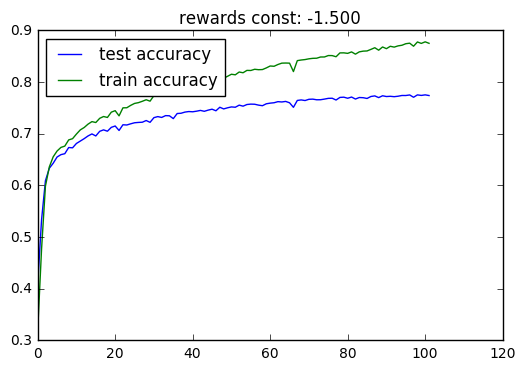

Train max accuracy:0.878
Test max accuracy:0.775


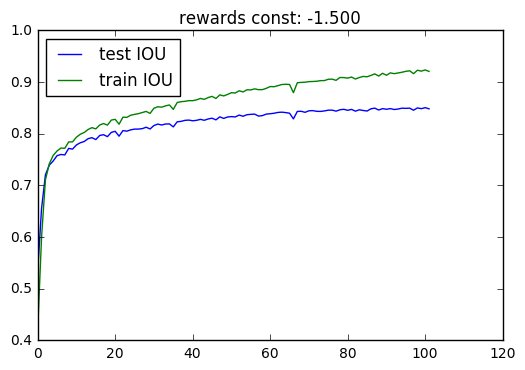

Train max IOU:0.924
Test max IOU:0.851


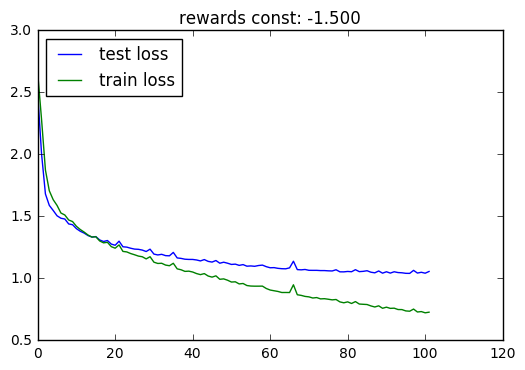

Train min loss:0.723
Test min loss:1.041
---------------------------------------------------------------------------------------------------- 



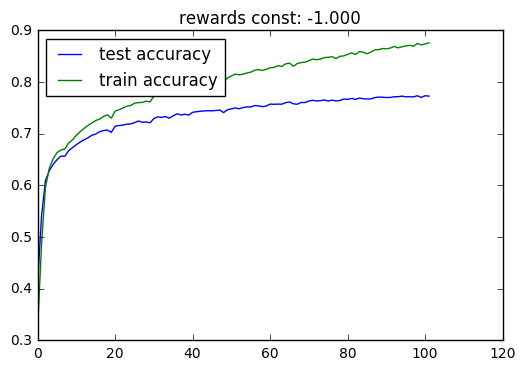

Train max accuracy:0.876
Test max accuracy:0.774


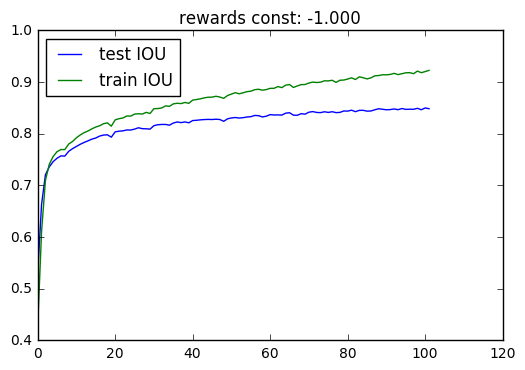

Train max IOU:0.923
Test max IOU:0.850


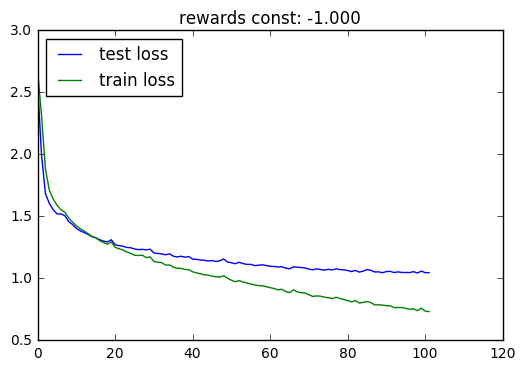

Train min loss:0.733
Test min loss:1.044
---------------------------------------------------------------------------------------------------- 



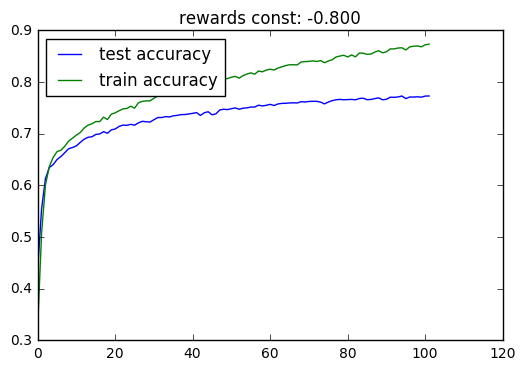

Train max accuracy:0.874
Test max accuracy:0.773


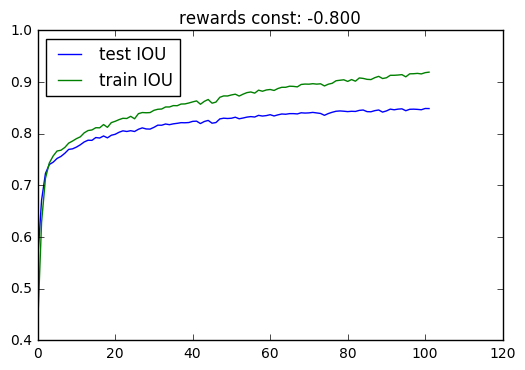

Train max IOU:0.919
Test max IOU:0.849


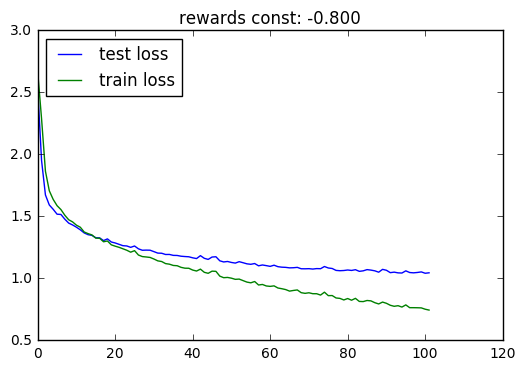

Train min loss:0.745
Test min loss:1.042
---------------------------------------------------------------------------------------------------- 



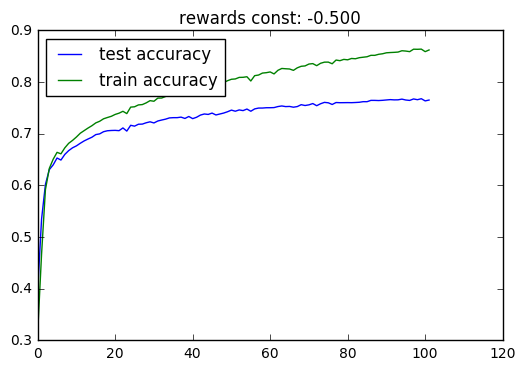

Train max accuracy:0.864
Test max accuracy:0.768


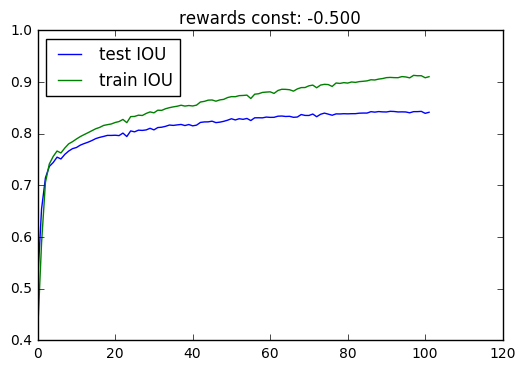

Train max IOU:0.913
Test max IOU:0.843


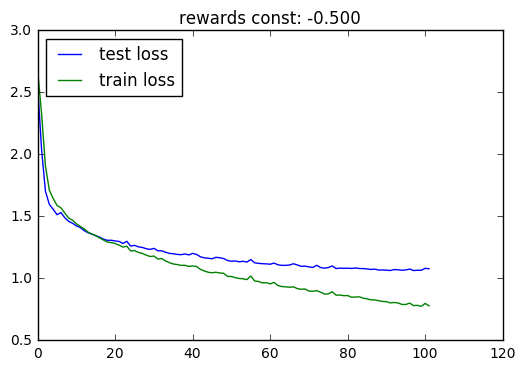

Train min loss:0.776
Test min loss:1.064
---------------------------------------------------------------------------------------------------- 



In [293]:
stats(rl_tst, Bue_trn, ephocs=102, title='rewards const', params=[-1.5, -1., -0.8, -0.5])

In [294]:
arr = []
for j, reward in enumerate([-1.5, -1., -0.8, -0.5]):
     arr.append([reward, 
           max(np.array(rl_tst[j])[:,0]), 
           max(np.array(Bue_trn[j])[:,0]), 
           max(np.array(rl_tst[j])[:,1]), 
           max(np.array(Bue_trn[j])[:,1]), 
           min(np.array(rl_tst[j])[:,2]), 
           min(np.array(Bue_trn[j])[:,2]),
           max(np.array(Bue_trn[j])[:,1])-max(np.array(rl_tst[j])[:,1]),
           min(np.array(rl_tst[j])[:,2]) - min(np.array(Bue_trn[j])[:,2])]) 
print(tabulate(arr, headers=['Reward', 'Test Accuracy', 'Train Accuracy', 'Test IOU', 
                             'Train IOU', 'Test Loss', 'Train Loss', 'Train IOU-Test IOU', 
                             'Train Loss-Test Loss'], tablefmt="fancy_grid"))

╒══════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╤══════════════════════╤════════════════════════╕
│   Reward │   Test Accuracy │   Train Accuracy │   Test IOU │   Train IOU │   Test Loss │   Train Loss │   Train IOU-Test IOU │   Train Loss-Test Loss │
╞══════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╪══════════════════════╪════════════════════════╡
│     -1.5 │        0.77532  │         0.877963 │   0.850556 │    0.923552 │     1.04077 │     0.722877 │            0.0729966 │               0.317891 │
├──────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┼──────────────────────┼────────────────────────┤
│     -1   │        0.773687 │         0.875926 │   0.849966 │    0.92271  │     1.04375 │     0.73272  │            0.0727441 │               0.311034 │
├──────────┼─────────────────┼──────────────────┼────────────┼─────────────┼

# Test vs Un-edited Train vs edited trained vs edit ratio

We check the result on the un-edited train set vs the edited train (in the same ehpoc, so the edit occurs while B's training) set vs the the results on the test set. We also take a look on the edit ratio.

In [402]:
# We take into account only the iteration in which edits were made (i.e. iteration>=14)
Bue_trn_tmp = np.array([Bue_trn[i][len(Bue_trn[0])-len(Be_trn[0]):] for i in range(4)])
rl_tst_tmp = np.array([rl_tst[i][len(Bue_trn[0])-len(Be_trn[0]):] for i in range(4)])

In [403]:
Bue_trn_tmp[0][:,0].shape

(96,)

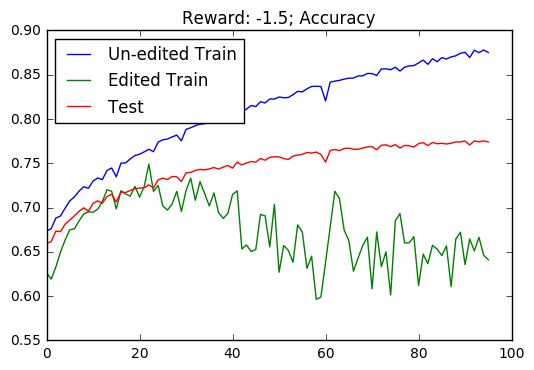

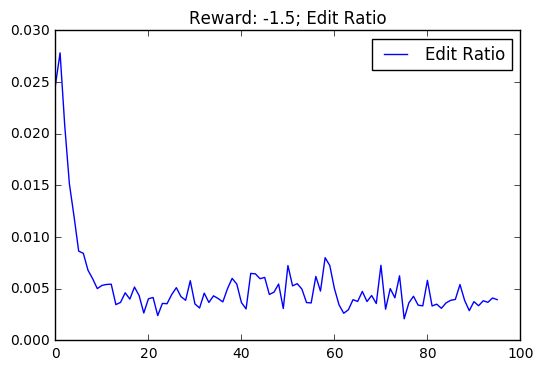

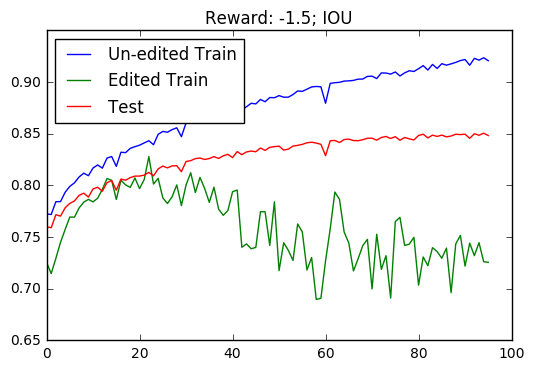

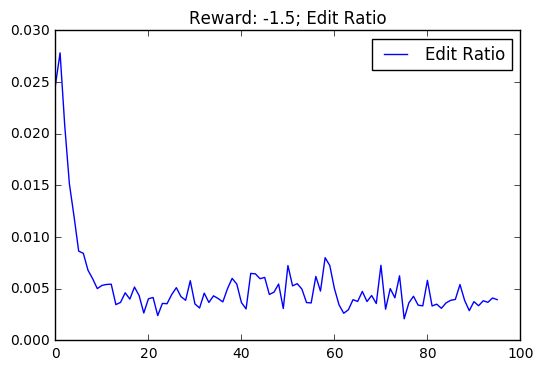

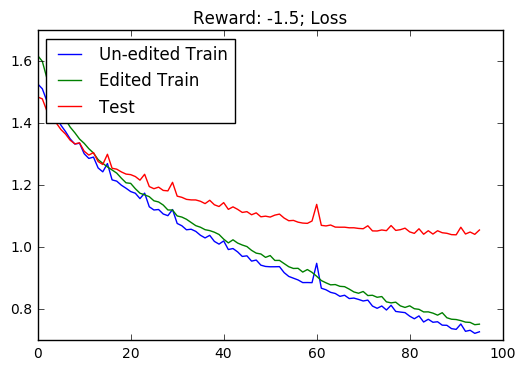

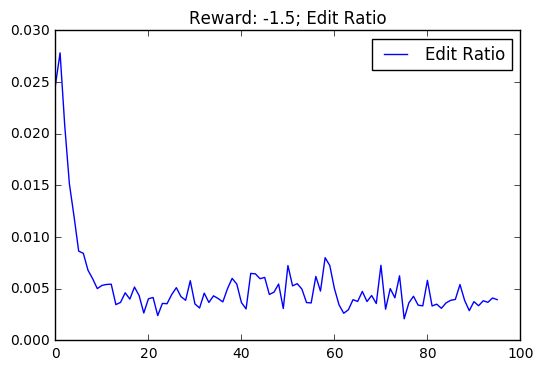

---------------------------------------------------------------------------------------------------- 



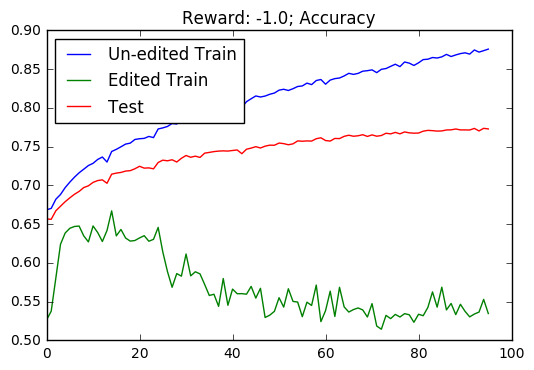

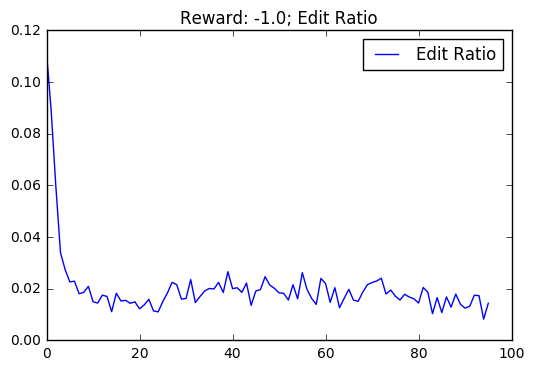

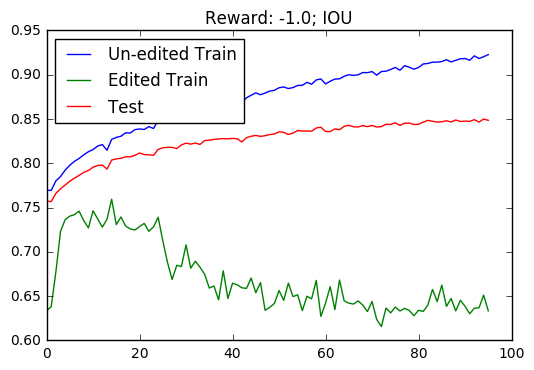

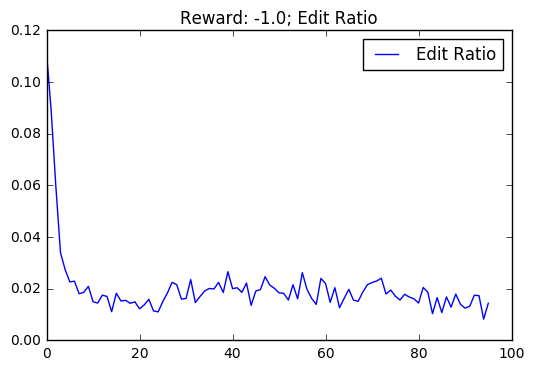

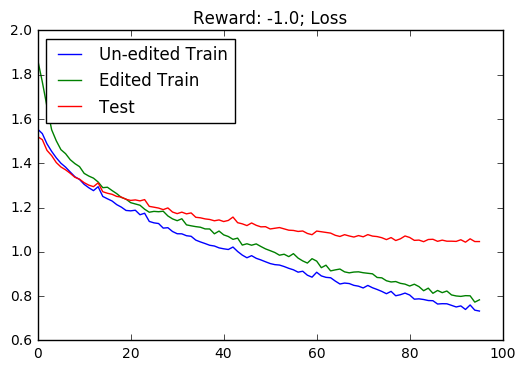

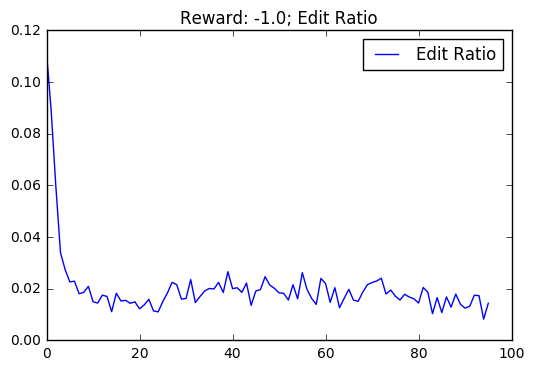

---------------------------------------------------------------------------------------------------- 



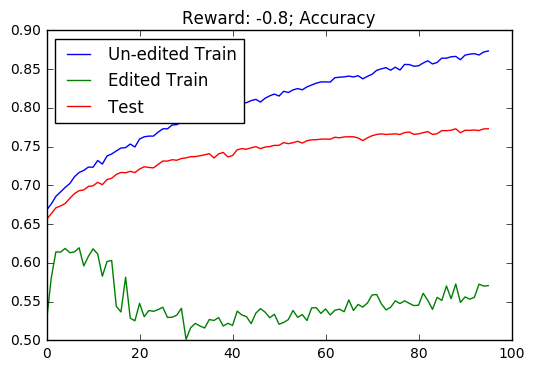

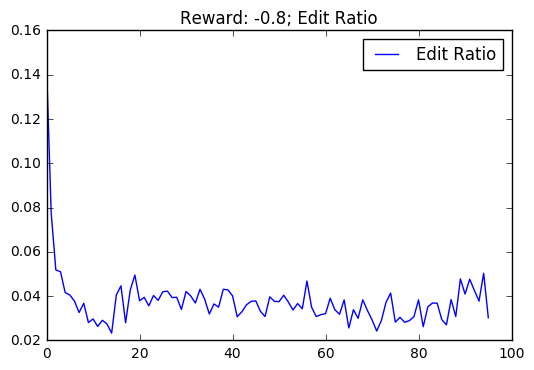

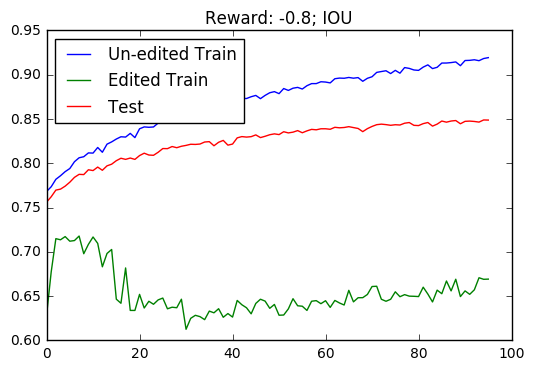

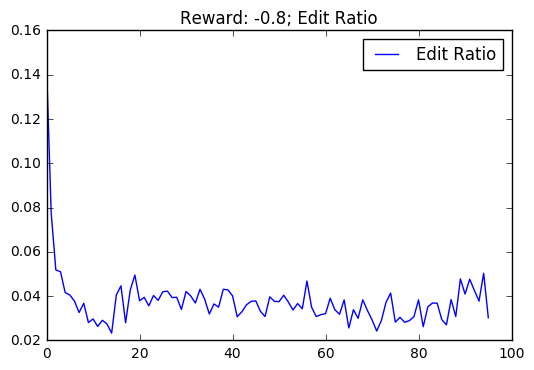

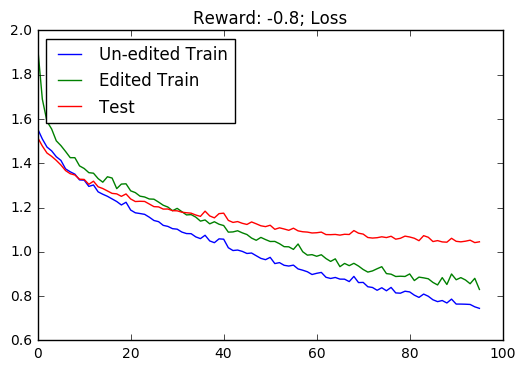

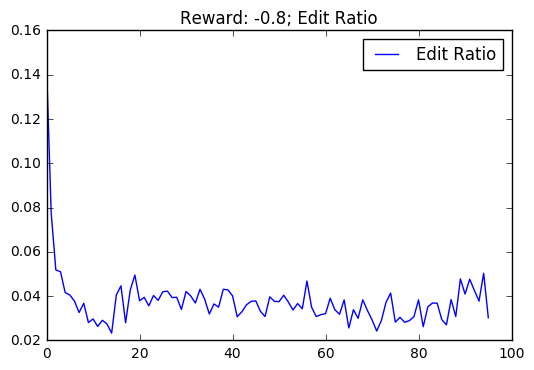

---------------------------------------------------------------------------------------------------- 



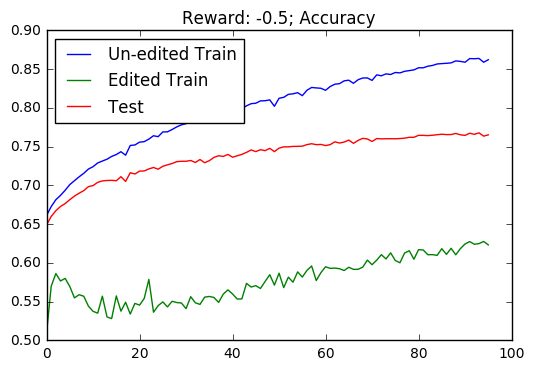

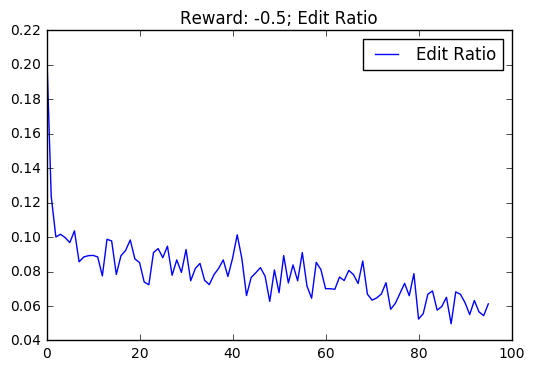

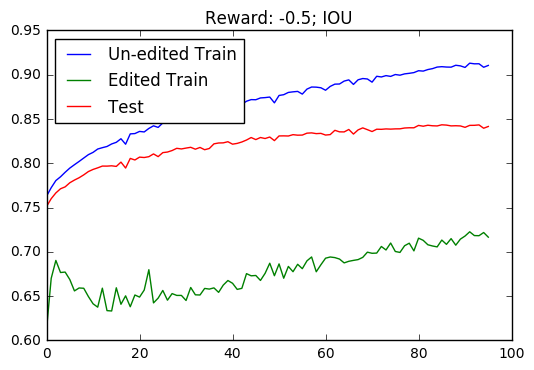

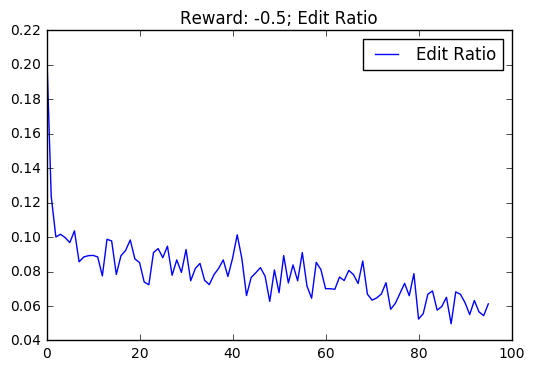

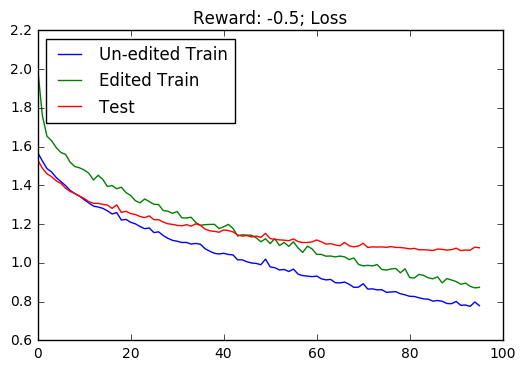

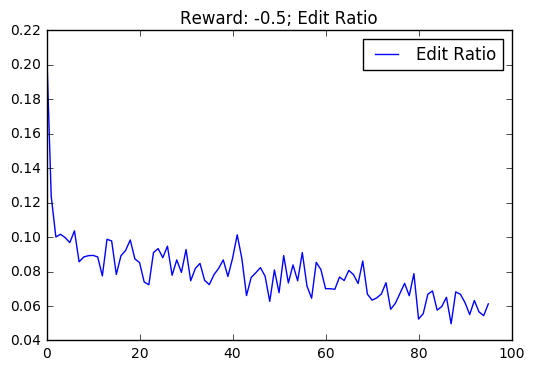

---------------------------------------------------------------------------------------------------- 



In [404]:
ephocs = range(96)
arr = ['Accuracy', 'IOU', 'Loss']
for j, param in enumerate([-1.5, -1., -0.8, -0.5]):
    for i in range(3):
        plt.plot(ephocs, np.array(Bue_trn_tmp)[j][:,i])
        plt.plot(ephocs, np.array(Be_trn)[j][:,i])
        plt.plot(ephocs, np.array(rl_tst_tmp)[j][:,i])
        plt.legend(['Un-edited Train', 'Edited Train', 'Test'], loc='upper left')
        plt.title('Reward: %0.1f; %s'%(param, arr[i]))
        plt.show()
        plt.plot(ephocs, np.array(Be_trn)[j][:,-1])
        plt.legend(['Edit Ratio'], loc='best' )
        plt.title('Reward: %0.1f; Edit Ratio'%(param))
        plt.show()
    print('-'*100,'\n')

# Test vs Ae-train vs edited trained vs edit ratio

We check the result on the un-edited train set vs the edited train (on the next ephoc, so the edits that we check occurs while only A's training) set vs the the results on the test set. We also take a look on the edit ratio.

In [405]:
# We take into account only the iteration in which edits were made (i.e. iteration>=14)
Bue_trn_tmp = np.array([Bue_trn[i][len(Bue_trn[0])-len(Be_trn[0]):-1] for i in range(4)])
rl_tst_tmp = np.array([rl_tst[i][len(Bue_trn[0])-len(Be_trn[0]):-1] for i in range(4)])
Ae_trn_tmp = np.array([[item for j, item in enumerate(Ae_trn[i]) if j%2==0]for i in range(4)])

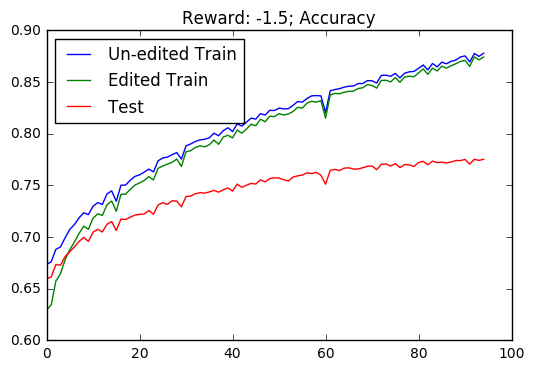

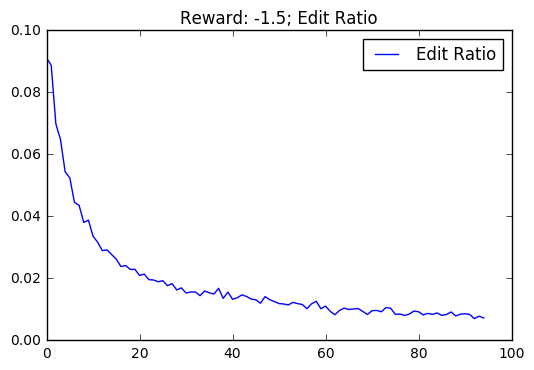

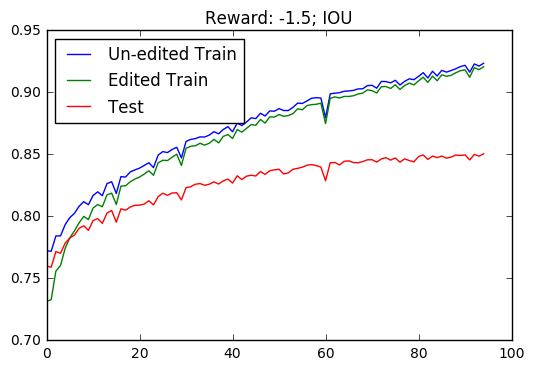

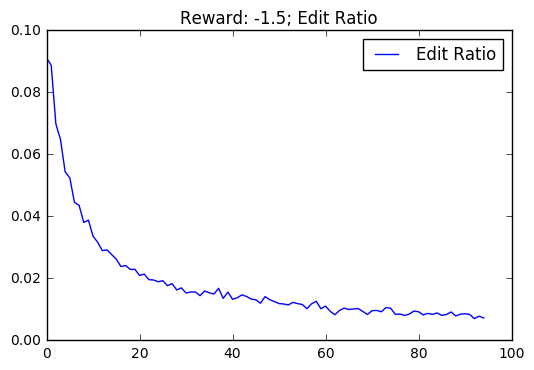

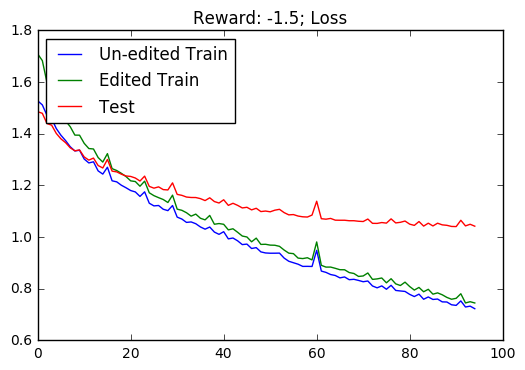

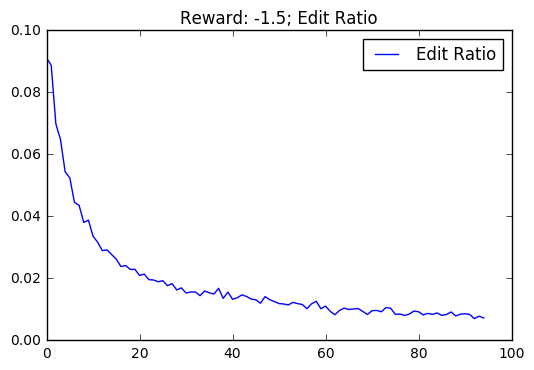

---------------------------------------------------------------------------------------------------- 



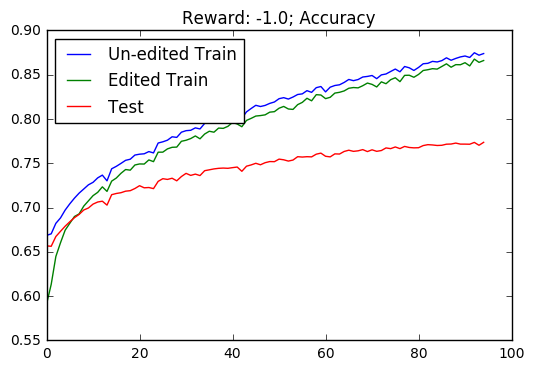

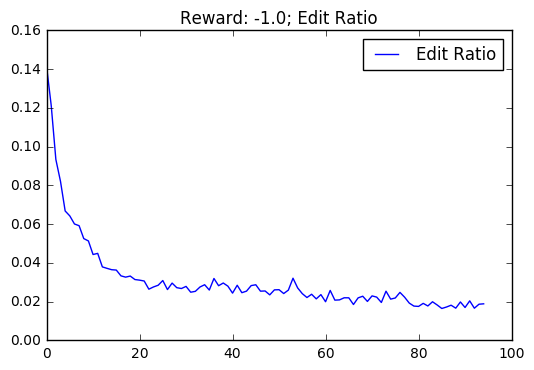

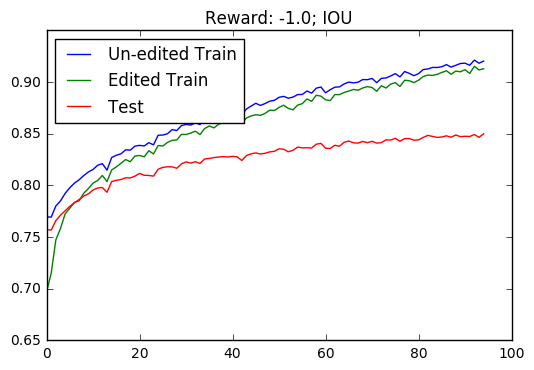

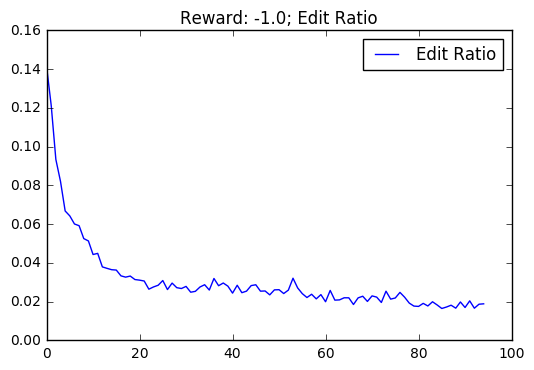

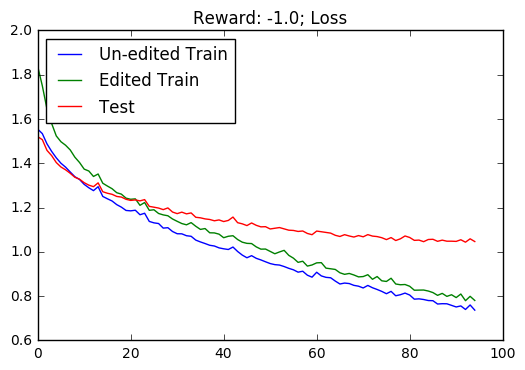

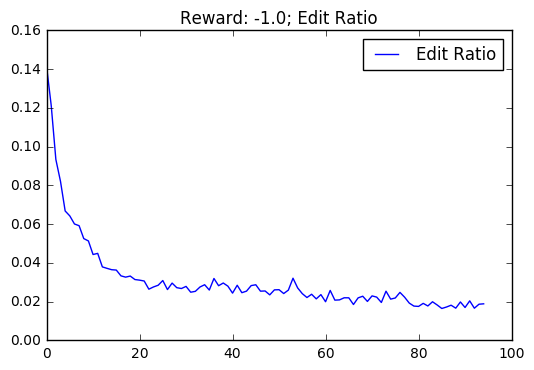

---------------------------------------------------------------------------------------------------- 



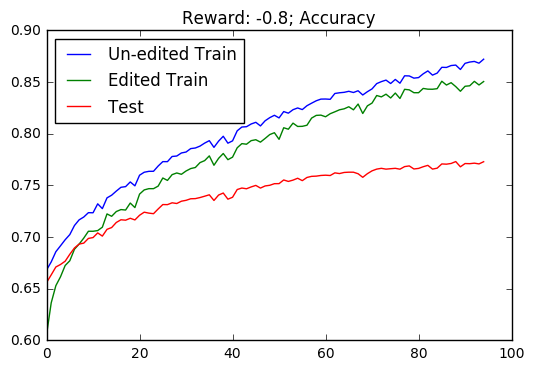

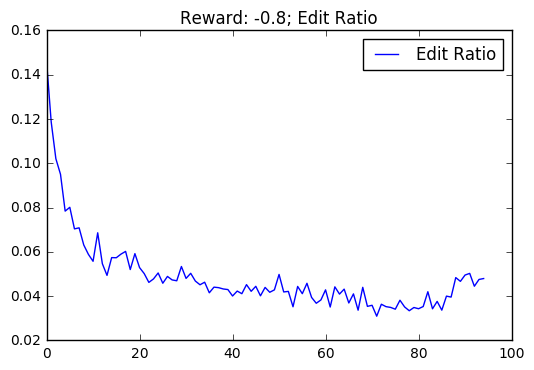

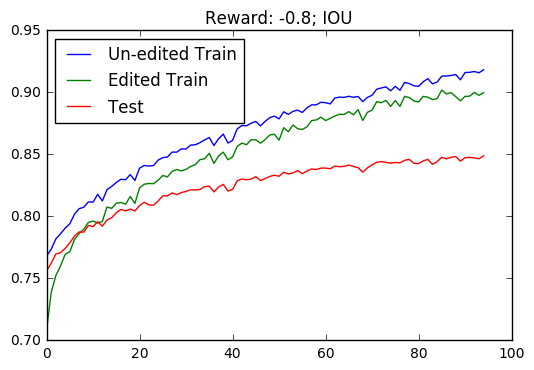

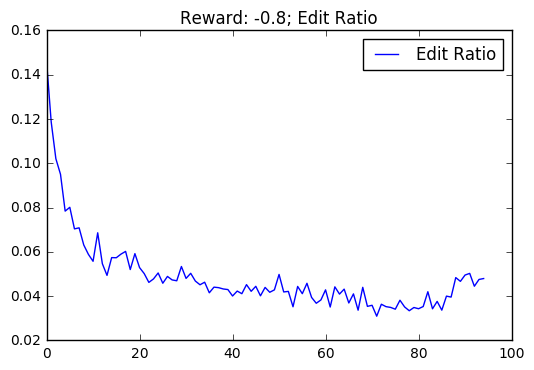

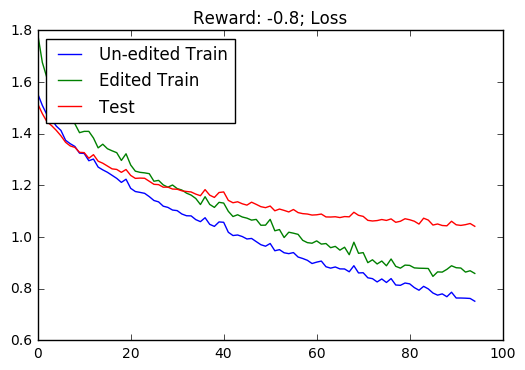

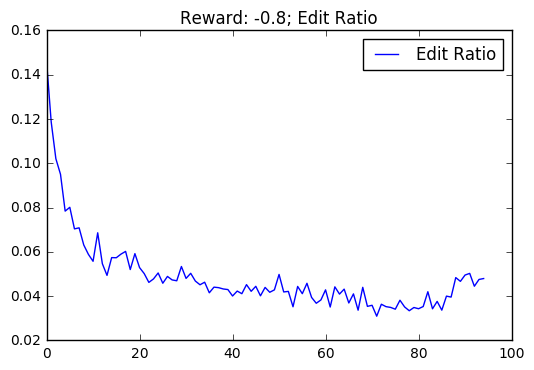

---------------------------------------------------------------------------------------------------- 



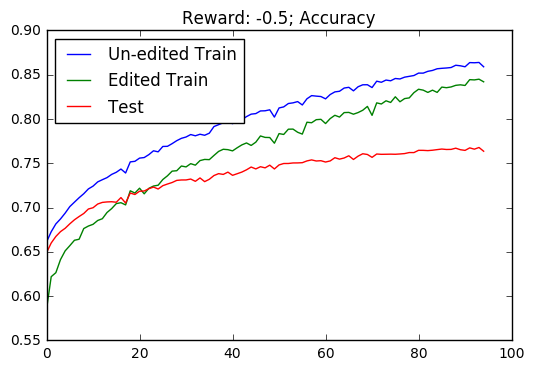

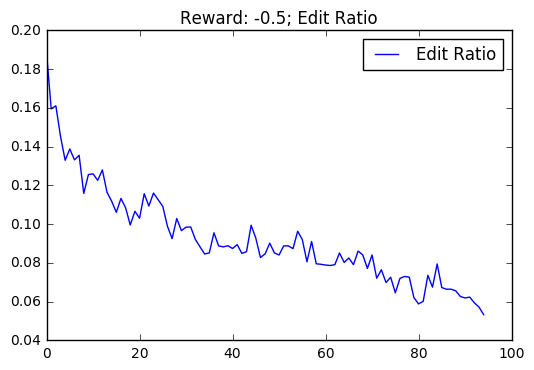

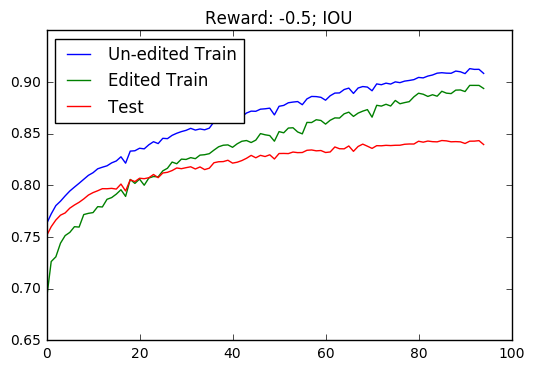

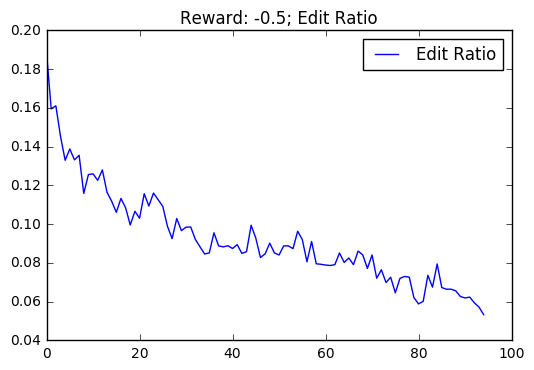

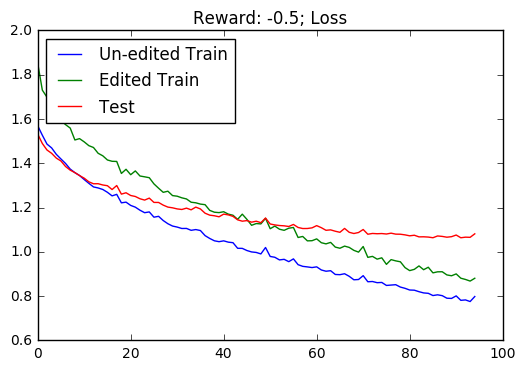

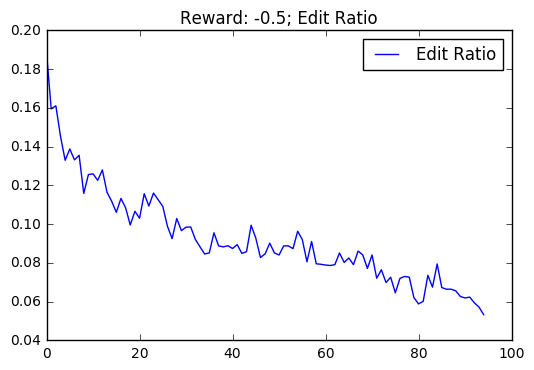

---------------------------------------------------------------------------------------------------- 



In [406]:
ephocs = range(95)
arr = ['Accuracy', 'IOU', 'Loss']
for j, param in enumerate([-1.5, -1., -0.8, -0.5]):
    for i in range(3):
        plt.plot(ephocs, np.array(Bue_trn_tmp)[j][:,i])
        plt.plot(ephocs, np.array(Ae_trn_tmp)[j][:,i])
        plt.plot(ephocs, np.array(rl_tst_tmp)[j][:,i])
        plt.legend(['Un-edited Train', 'Edited Train', 'Test'], loc='upper left')
        plt.title('Reward: %0.1f; %s'%(param, arr[i]))
        plt.show()
        plt.plot(ephocs, np.array(Ae_trn_tmp)[j][:,-1])
        plt.legend(['Edit Ratio'], loc='best')
        plt.title('Reward: %0.1f; Edit Ratio'%(param))
        plt.show()
    print('-'*100,'\n')

# ATest vs RandTest vs Ae-train vs edit ratio

We examine the result on the test set while activating A vs randomly edit words (with the same ratio we got while A edited the words). We also look at the result on the train set while A edits and B is not training.<br>
We then check the edit ratio on the training set and the test set.


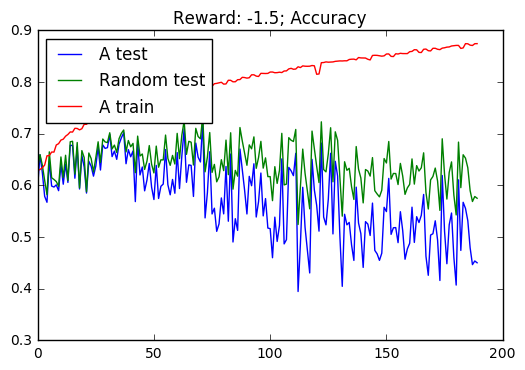

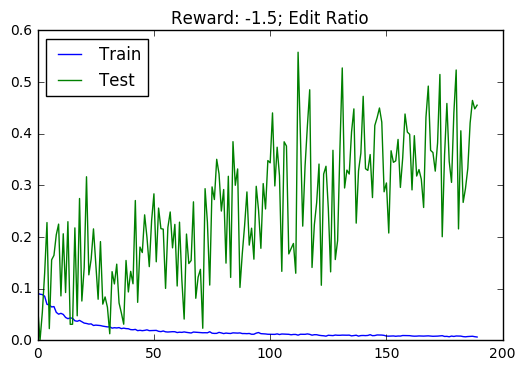

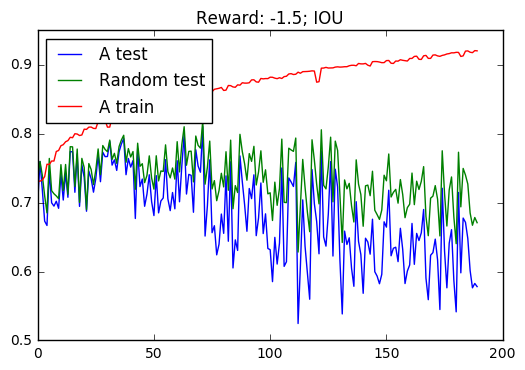

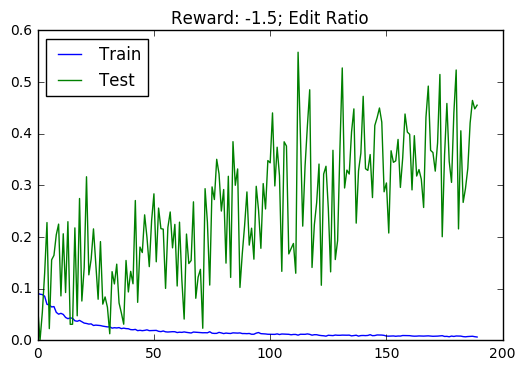

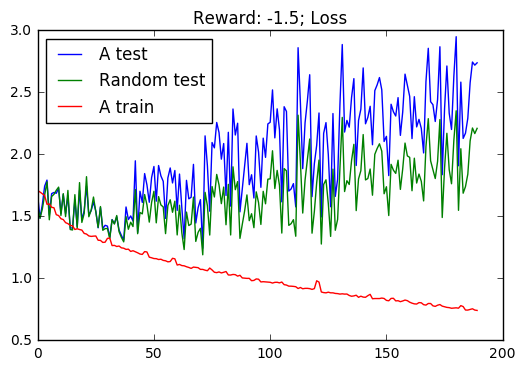

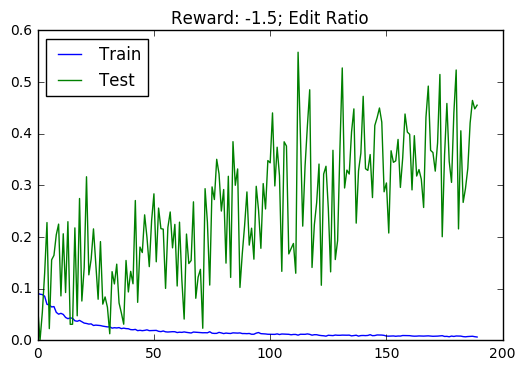

---------------------------------------------------------------------------------------------------- 



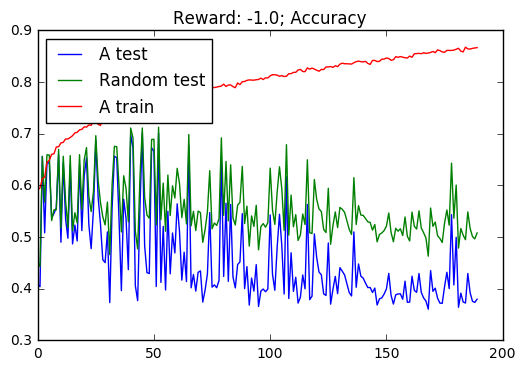

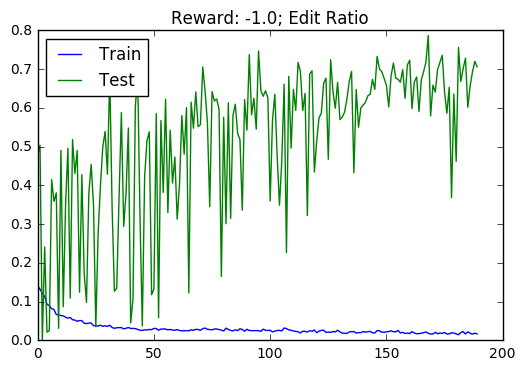

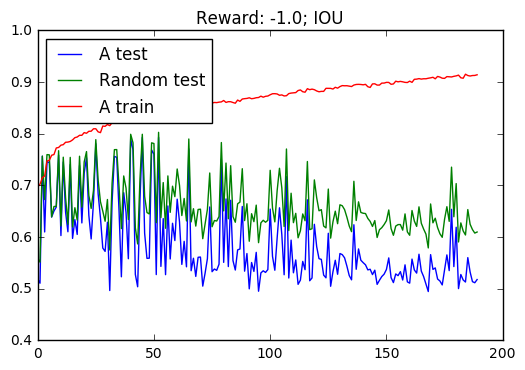

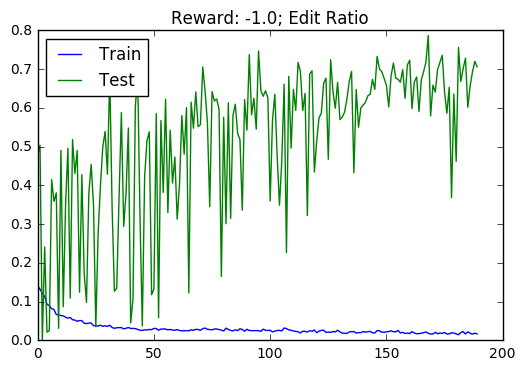

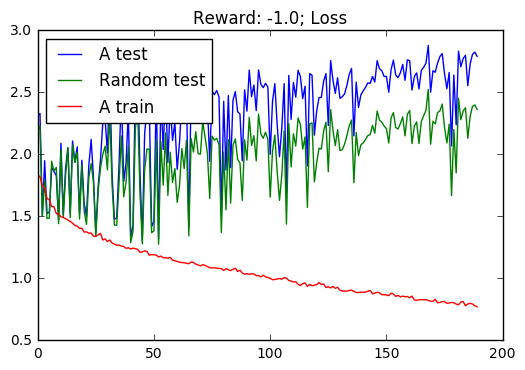

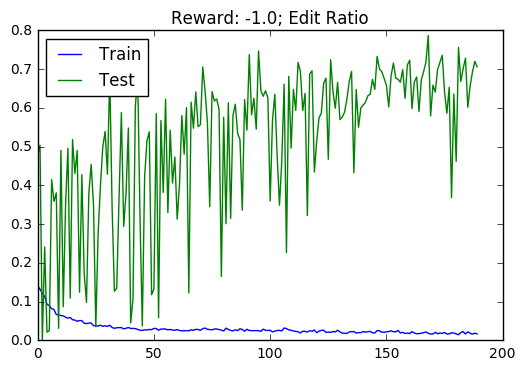

---------------------------------------------------------------------------------------------------- 



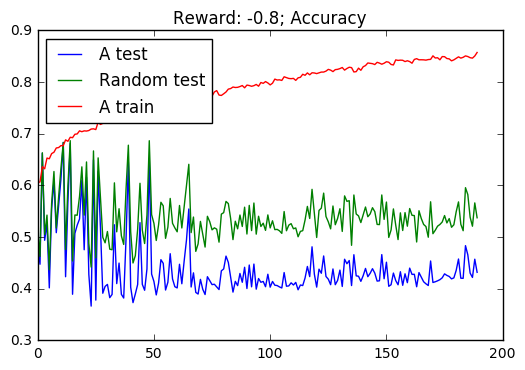

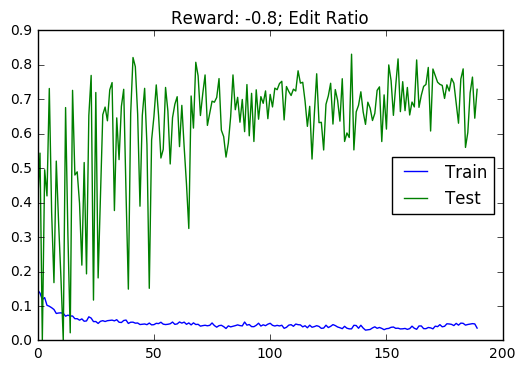

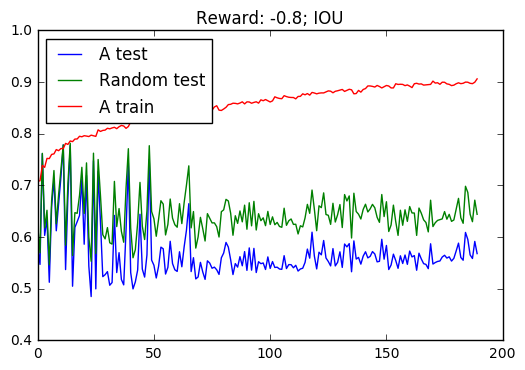

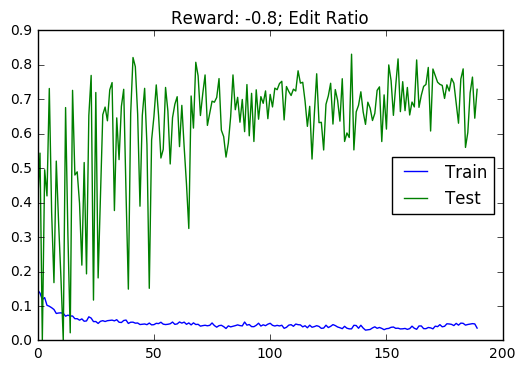

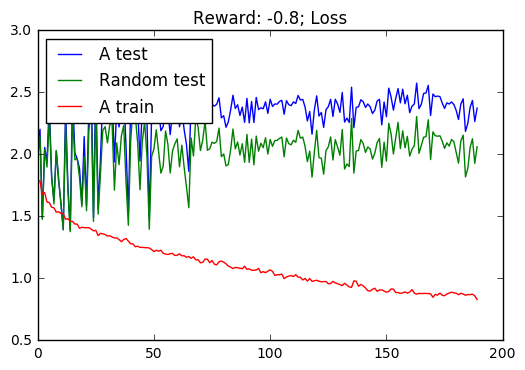

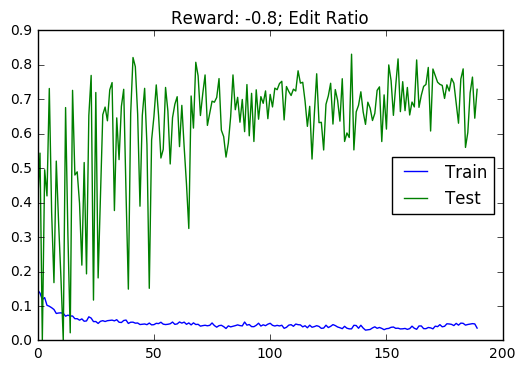

---------------------------------------------------------------------------------------------------- 



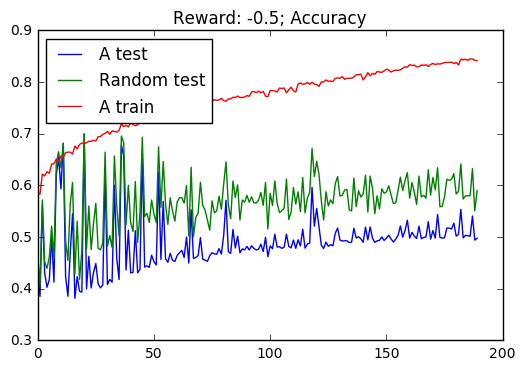

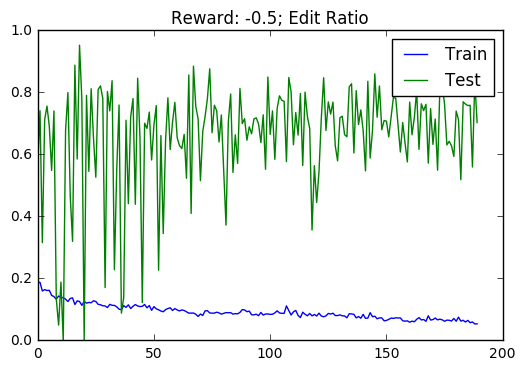

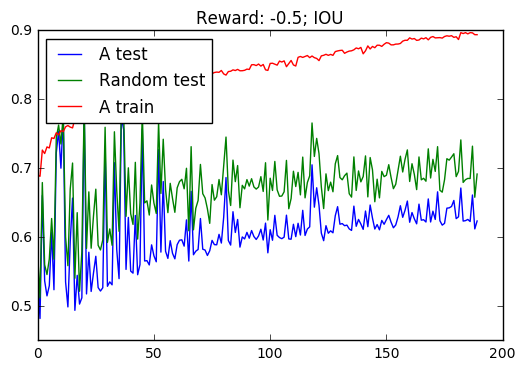

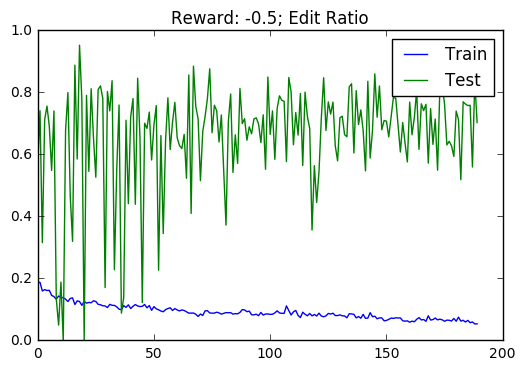

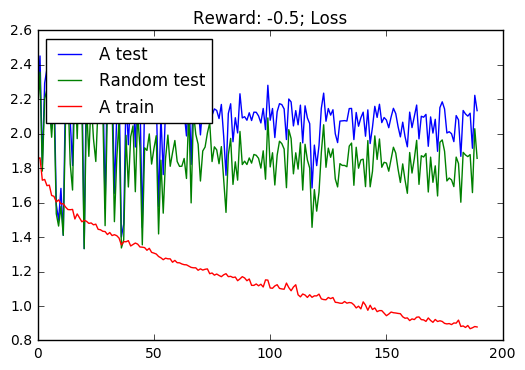

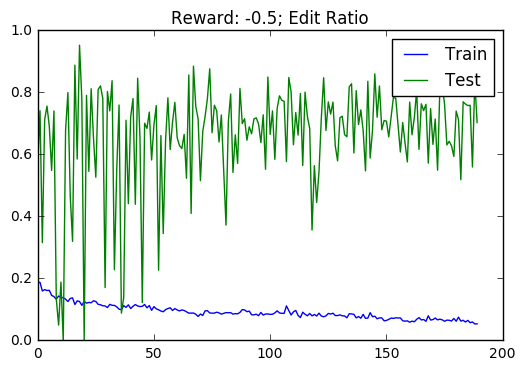

---------------------------------------------------------------------------------------------------- 



In [407]:
ephocs = range(190)
arr = ['Accuracy', 'IOU', 'Loss']
for j, param in enumerate([-1.5, -1., -0.8, -0.5]):
    for i in range(3):
        plt.plot(ephocs, np.array(Ae_tst)[j][:,i])
        plt.plot(ephocs, np.array(Re_tst)[j][:,i])
        plt.plot(ephocs, np.array(Ae_trn)[j][:,i])
        plt.legend(['A test', 'Random test', 'A train'], loc='upper left')
        plt.title('Reward: %0.1f; %s'%(param, arr[i]))
        plt.show()
        
        plt.plot(ephocs, np.array(Ae_trn)[j][:,-1])
        plt.plot(ephocs, np.array(Ae_tst)[j][:,-1])
        plt.legend(['Train', 'Test'], loc='best')
        plt.title('Reward: %0.1f; Edit Ratio'%(param))
        plt.show()
    print('-'*100,'\n')

# Un-edited train vs Test and Edit ratio on the train set vs Edit ratio on the test set 

In [420]:
# We take into account only the iteration in which edits were made (i.e. iteration>=14)
Bue_trn_tmp = np.array([Bue_trn[i][len(Bue_trn[0])-len(Be_trn[0]):-1] for i in range(4)])
rl_tst_tmp = np.array([rl_tst[i][len(Bue_trn[0])-len(Be_trn[0]):-1] for i in range(4)])
Ae_trn_tmp = np.array([[item for j, item in enumerate(Ae_trn[i]) if j%2==0]for i in range(4)])
Ae_tst_tmp = np.array([[item for j, item in enumerate(Ae_tst[i]) if j%2==0]for i in range(4)])

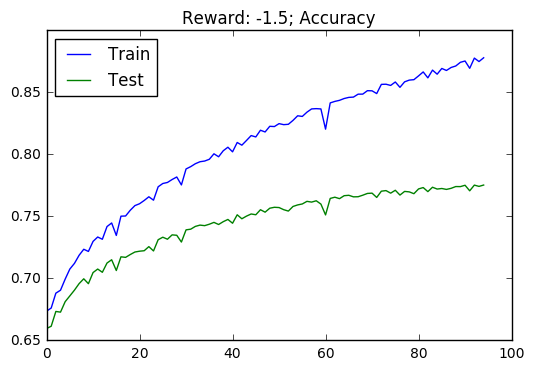

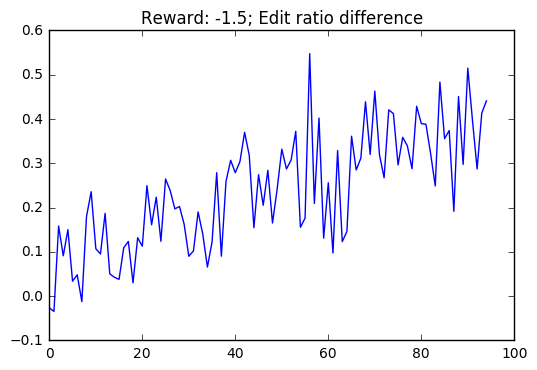

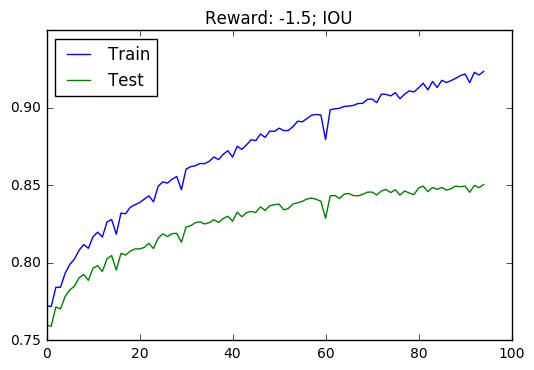

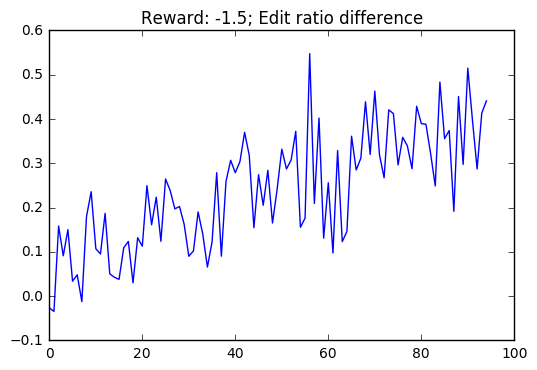

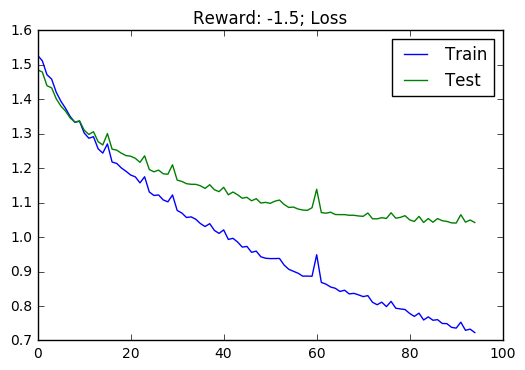

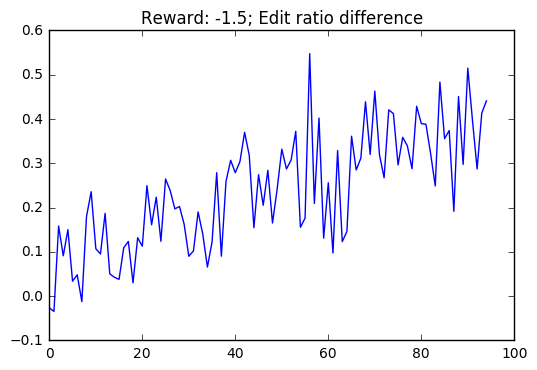

---------------------------------------------------------------------------------------------------- 



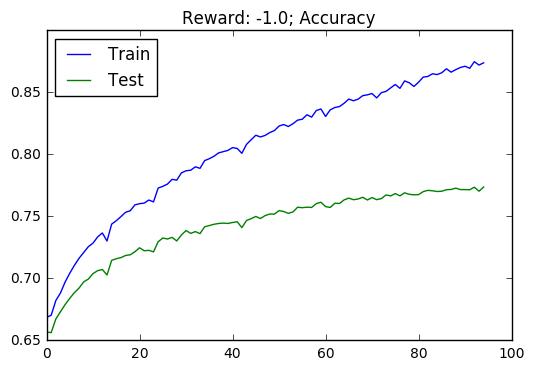

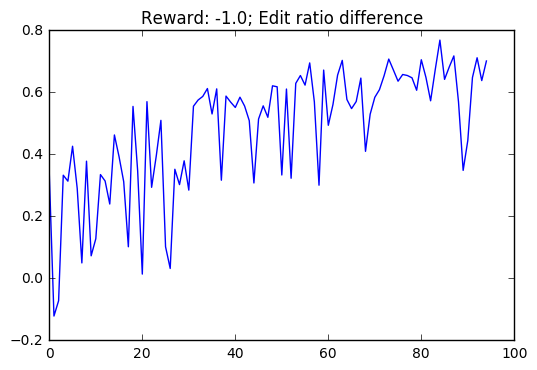

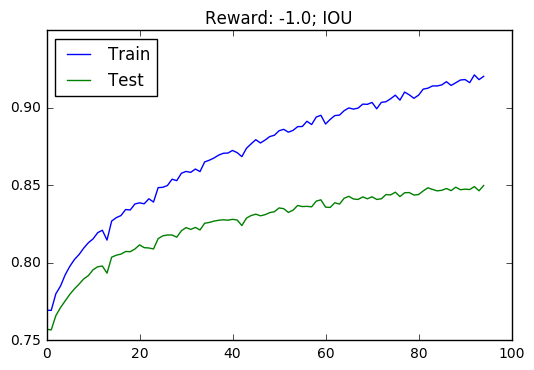

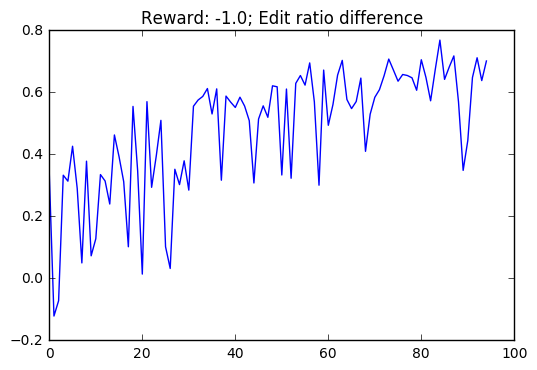

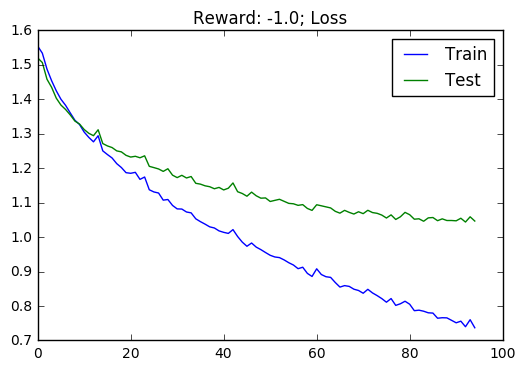

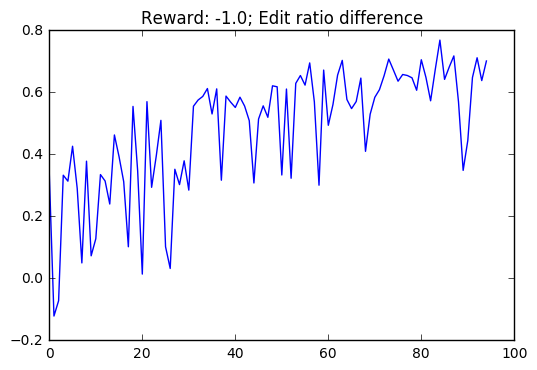

---------------------------------------------------------------------------------------------------- 



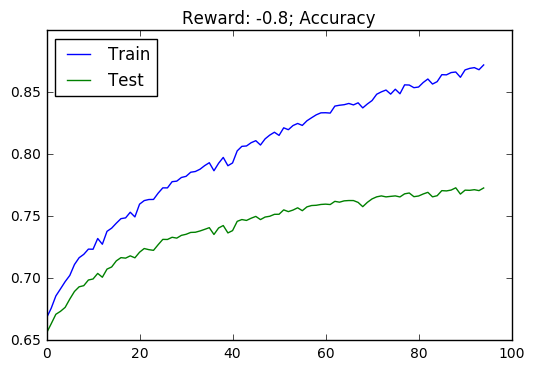

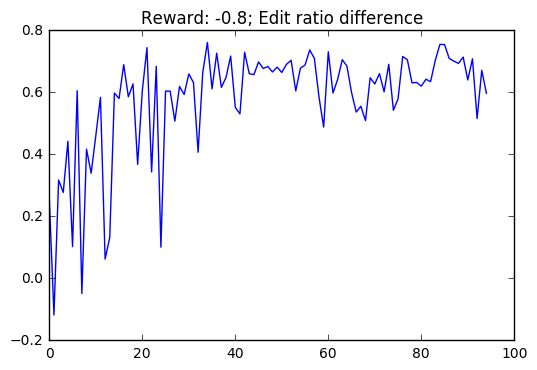

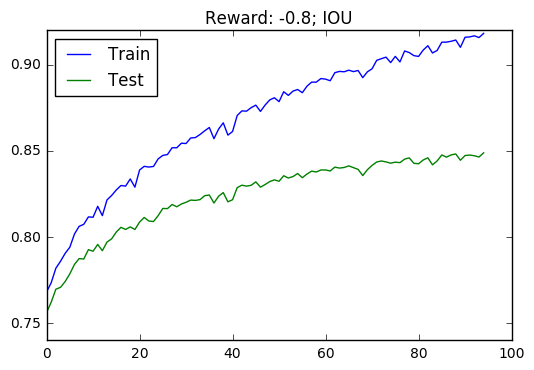

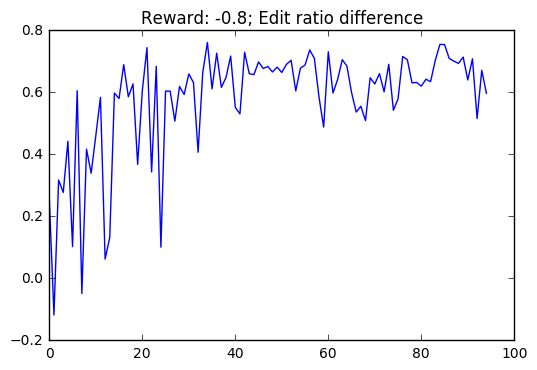

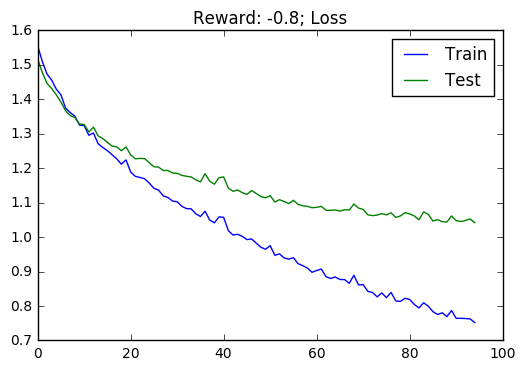

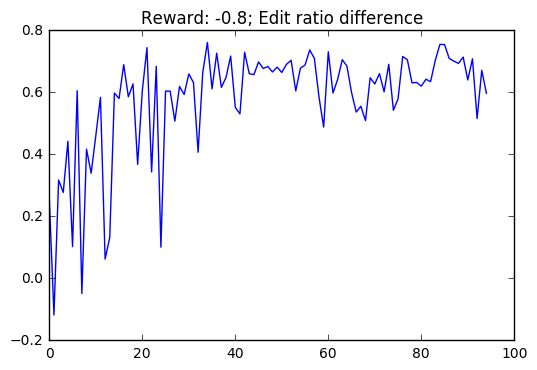

---------------------------------------------------------------------------------------------------- 



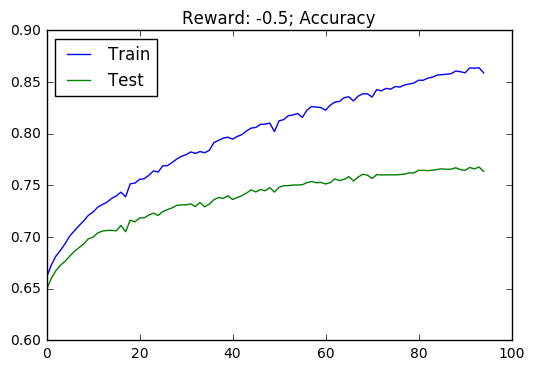

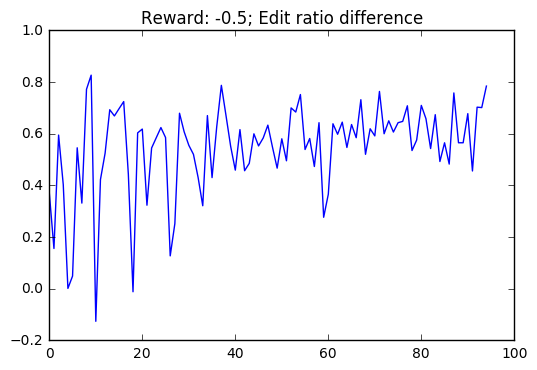

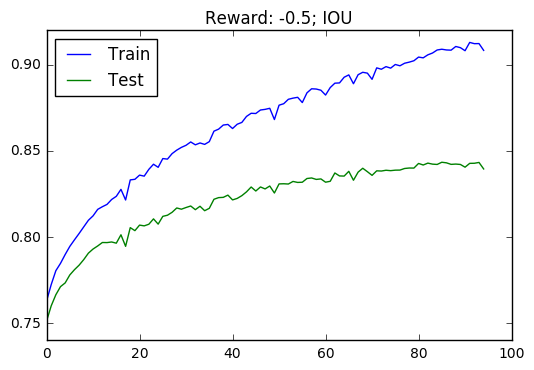

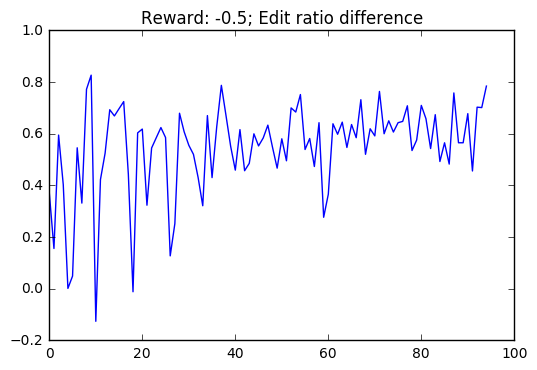

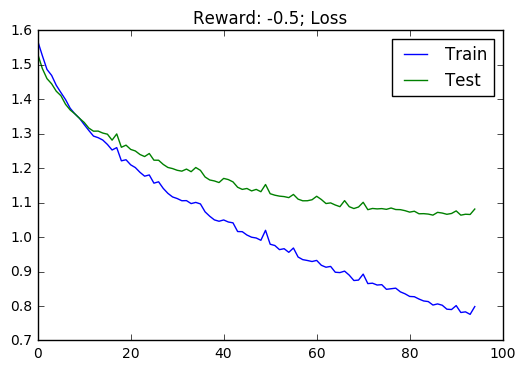

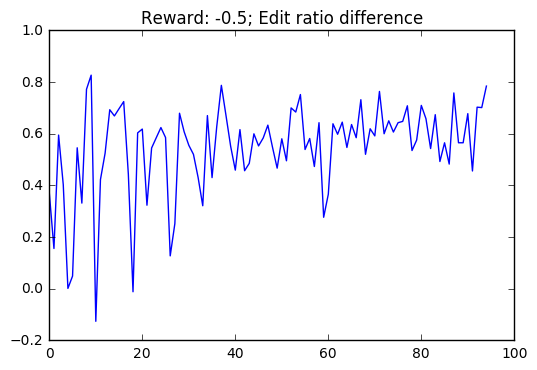

---------------------------------------------------------------------------------------------------- 



In [421]:
ephocs = range(95)
arr = ['Accuracy', 'IOU', 'Loss']
for j, param in enumerate([-1.5, -1., -0.8, -0.5]):
    for i in range(3):
        plt.plot(ephocs, np.array(Bue_trn_tmp)[j][:,i])
        plt.plot(ephocs, np.array(rl_tst_tmp)[j][:,i])
        plt.legend(['Train', 'Test'], loc='best' )
        plt.title('Reward: %0.1f; %s'%(param, arr[i]))
        plt.show()
        
        plt.plot(ephocs, Ae_tst_tmp[j][:,-1]-Ae_trn_tmp[j][:,-1])
        plt.title('Reward: %0.1f; Edit ratio difference'%(param))
        plt.show()
    print('-'*100,'\n')